In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings


## Load Data

### Migration influx

In [2]:
with open("../migration_rates/countries.json") as buf:
    countries = list(json.load(buf).keys())

df_all = pd.read_csv(
    "../migration_rates/migration_rate_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")

for c in countries:
    df_all.loc[df_all["country"] == c, "value"].fillna(
        df_all.loc[df_all["country"] == c].mean(), inplace=True
    )  # fill missing data with mean

series = {c: df_all[df_all.country == c].value for c in countries}
series["NL"]


date
2010-01-01     763.0
2010-02-01     649.0
2010-03-01     768.0
2010-04-01     772.0
2010-05-01     685.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 120, dtype: float64

### Google trends

In [3]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../keywords/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../processed_data/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]]["mean"].columns.to_list()
dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

### Macroeconomics

In [4]:
def read_gdp(filename, country_names, skiprows=10, nrows=38):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows)

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df[df["GEO/TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("GEO/TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "gdp", "GEO/TIME": "country"})
    )
    df.index = pd.to_datetime(df.index)
    return df


def read_unempl(filename, country_names, skiprows=10, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Sheet 1")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "unempl", "TIME": "country"})
        .replace({":": np.nan})
    )

    df.index = pd.to_datetime(df.index)
    return df


def read_share_young_pop(filename, country_names, skiprows=9, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Share Young Pop")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "share_young_pop", "TIME": "country"})
    )

    df.index = pd.to_datetime(df.index)
    return df


with open("../macroeconomics/country_names.json") as f:
    country_names = json.load(f)

df_gdp = read_gdp("../macroeconomics/GDP_pc_quart.xls", country_names)
df_unempl = read_unempl("../macroeconomics/Unemployment_Rate_Quart.xlsx", country_names)
df_share_young_pop = read_share_young_pop("../macroeconomics/Share_Young_Population.xlsx", country_names)
df_share_young_pop
# df_unempl


country  share_young_pop
2004-01-01      BE         0.183531
2004-01-01      BG         0.209908
2004-01-01      CZ         0.225508
2004-01-01      DK         0.176100
2004-01-01      EE         0.217808
...            ...              ...
2019-01-01      LU         0.191188
2019-01-01      HU         0.171723
2019-01-01      NL         0.188275
2019-01-01      AT         0.177618
2019-01-01      PL         0.171216

[304 rows x 2 columns]

### Resample, transform and merge

In [5]:
dfs_1m = {k: df.diff() for k, df in dataframes.items()}
sers_1m = {k: df.pct_change() for k, df in series.items()}

tmp_dfs = []

for c in countries:
    tmp_dep = (
        sers_1m[c]
        .to_frame()
        .assign(country=c)
        .assign(prev1=sers_1m[c].shift(1))
        .assign(prev2=sers_1m[c].shift(2))
        .assign(prev2_neg=-sers_1m[c].shift(2))
        .assign(month=sers_1m[c].index.month.astype(str))
    )
    tmp_ind = dfs_1m[c]["mean"].shift(1)
    tmp_df = pd.concat([tmp_dep, tmp_ind], axis=1)["2010-12-31":"2019-12-31"]
    tmp_dfs.append(tmp_df)

df_panel_1y = pd.concat(tmp_dfs).sort_index()

for df in [df_share_young_pop, df_gdp, df_unempl]:
    df_tmp = df.groupby([pd.Grouper(freq="1M"), "country"]).mean().shift(1).pct_change()
    df_panel_1y = df_panel_1y.join(
        df_tmp, on=[df_panel_1y.index, df_panel_1y["country"]], how="left"
    )

df_panel_1y


value country     prev1     prev2  prev2_neg month         2  \
date                                                                          
2011-01-01  0.493590      FR -0.357364 -0.551294   0.551294     1  0.000000   
2011-01-01  0.405063      IE -0.318966 -0.392670   0.392670     1  0.000000   
2011-01-01  0.155833      GR -0.201848 -0.128793   0.128793     1  0.000000   
2011-01-01  0.252549      HU -0.340846 -0.104462   0.104462     1  0.000000   
2011-01-01  0.556338      BG -0.378556 -0.067109   0.067109     1  0.000000   
...              ...     ...       ...       ...        ...   ...       ...   
2019-12-01 -0.256098      IE -0.456954 -0.350538   0.350538    12  0.000000   
2019-12-01 -0.106748      NL -0.180080 -0.120354   0.120354    12  9.285714   
2019-12-01  0.000000      SK -0.265527 -0.072621   0.072621    12  0.000000   
2019-12-01 -0.407080      FI -0.392473 -0.436364   0.436364    12  0.000000   
2019-12-01  0.101382      LU -0.645425  0.200000  -0.200000    12  0.000000   

                   10         11         12  ...        118        119  \
date                                         ...                         
2011-01-01 -15.428571   9.000000   6.142857  ...  -6.142857 -11.428571   
2011-01-01   0.000000  22.571429   0.000000  ... -21.714286 -14.285714   
2011-01-01   0.000000   0.000000   0.000000  ...   2.857143  -9.714286   
2011-01-01   0.000000   0.000000   0.000000  ... -14.571429 -15.285714   
2011-01-01   0.000000   9.428571 -46.428571  ... -17.000000 -19.714286   
...               ...        ...        ...  ...        ...        ...   
2019-12-01   0.000000  -3.714286   0.000000  ...  -4.714286   5.428571   
2019-12-01 -11.285714  -4.428571  24.857143  ...   0.857143   1.000000   
2019-12-01   0.000000   0.000000   0.000000  ... -10.571429  -2.285714   
2019-12-01   0.000000   0.000000   0.000000  ...   6.000000  -0.285714   
2019-12-01   0.000000 -43.714286   0.000000  ... -10.571429  -1.571429   

                  121        122        123        124        125  \
date                                                                
2011-01-01  -3.714286 -12.714286  -9.428571  -5.571429  -3.285714   
2011-01-01  -6.714286  -9.428571 -23.714286 -11.000000  -6.571429   
2011-01-01   7.428571 -16.857143 -10.000000  -6.857143  13.857143   
2011-01-01   1.142857 -11.857143 -19.428571  -2.285714  -0.714286   
2011-01-01  -2.857143  -0.571429 -20.571429  -2.285714  -0.571429   
...               ...        ...        ...        ...        ...   
2019-12-01  -4.142857  -2.142857  -5.571429   0.714286  11.285714   
2019-12-01   2.857143  -6.857143  -0.857143   7.142857  11.142857   
2019-12-01  -0.142857  16.857143  -3.857143  -3.142857 -10.714286   
2019-12-01  15.857143  -8.571429  -0.571429   5.571429   6.571429   
2019-12-01 -12.571429   6.428571  -6.000000  15.000000   0.000000   

            share_young_pop  gdp  unempl  
date                                      
2011-01-01              NaN  NaN     NaN  
2011-01-01              NaN  NaN     NaN  
2011-01-01              NaN  NaN     NaN  
2011-01-01              NaN  NaN     NaN  
2011-01-01              NaN  NaN     NaN  
...                     ...  ...     ...  
2019-12-01              NaN  NaN     NaN  
2019-12-01              NaN  NaN     NaN  
2019-12-01              NaN  NaN     NaN  
2019-12-01              NaN  NaN     NaN  
2019-12-01              NaN  NaN     NaN  

[2916 rows x 57 columns]

## Evaluation functions and common variables

In [6]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import feature_selection
from sklearn import compose
from sklearn import impute

t_min = "2011-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

scoring = ["neg_mean_absolute_percentage_error", "neg_root_mean_squared_error", "r2"]

# selected_countries = ["FR", "GB", "IT", "ES", "RO"]
selected_countries = countries


df_panel_1y = df_panel_1y[df_panel_1y.country.isin(selected_countries)]

dummies_country = pd.get_dummies(df_panel_1y["country"], drop_first=False)
dummy_cols = dummies_country.columns.tolist()

dummies_month = pd.get_dummies(df_panel_1y["month"], prefix="month", drop_first=False)
dummy_cols_month = dummies_month.columns.tolist()

df_tmp_combined = df_panel_1y["country"] + "_" + df_panel_1y["month"]
dummies_combined = pd.get_dummies(df_tmp_combined, drop_first=False)
dummy_cols_combined = dummies_combined.columns.tolist()

df_panel_1y = pd.concat(
    [df_panel_1y, dummies_country, dummies_month, dummies_combined], axis=1
)

x = df_panel_1y.drop(columns="value")[t_min:t_max]
y = df_panel_1y["value"][t_min:t_max]

x_train = x[t_min:t_split_lower]
y_train = y[t_min:t_split_lower]
x_test = x[t_split_upper:t_max]
y_test = y[t_split_upper:t_max]


def score_cv(reg, X, y):
    scores = model_selection.cross_validate(reg, X=X, y=y, scoring=scoring)
    return pd.DataFrame(scores)


def score_test(reg, X, y):
    scores = {s: metrics.get_scorer(s)(reg, X, y) for s in scoring}
    return pd.Series(scores)


def plot_panel(df, countries, n_rows=7, n_cols=4, figsize=(25, 25), autoscale=True):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(countries, axs.flatten()):
        df_to_plot = df[df["country"] == c].drop(columns="country")
        if autoscale is not None:
            y_max = max([df_to_plot[col].max() for col in df_to_plot.columns])
            y_min = min([df_to_plot[col].min() for col in df_to_plot.columns])
        df_to_plot.plot(ax=ax, ylim=(y_min * 1.2, y_max * 1.2) if autoscale else None)
        ax.set_title(c)
    fig.tight_layout()
    return fig, axs


def plot_prediction(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    return plot_panel(df_pred, countries, **kwargs)


def plot_residuals(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    df_pred["residuals"] = df_pred["pred"] - df_pred["value"]
    return plot_panel(df_pred[["residuals", "country"]], countries, **kwargs)



## Models

### Country dummies

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.007162    0.011777                            -5.424903e+11   
1  0.011572    0.012277                            -1.002638e+12   
2  0.008895    0.006052                            -1.603217e+00   
3  0.009734    0.004465                            -1.087376e+12   
4  0.008183    0.004307                            -3.201448e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.334565 -0.015438  
1                         -0.364486  0.001059  
2                         -0.362997 -0.015490  
3                         -0.344515  0.004829  
4                         -0.337412 -0.012341

Mean CV score:


fit_time                                   9.109354e-03
score_time                                 7.775688e-03
test_neg_mean_absolute_percentage_error   -1.166790e+12
test_neg_root_mean_squared_error          -3.487949e-01
test_r2                                   -7.476289e-03
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.179600e+13
neg_root_mean_squared_error          -3.373327e-01
r2                                    1.657383e-03
dtype: float64

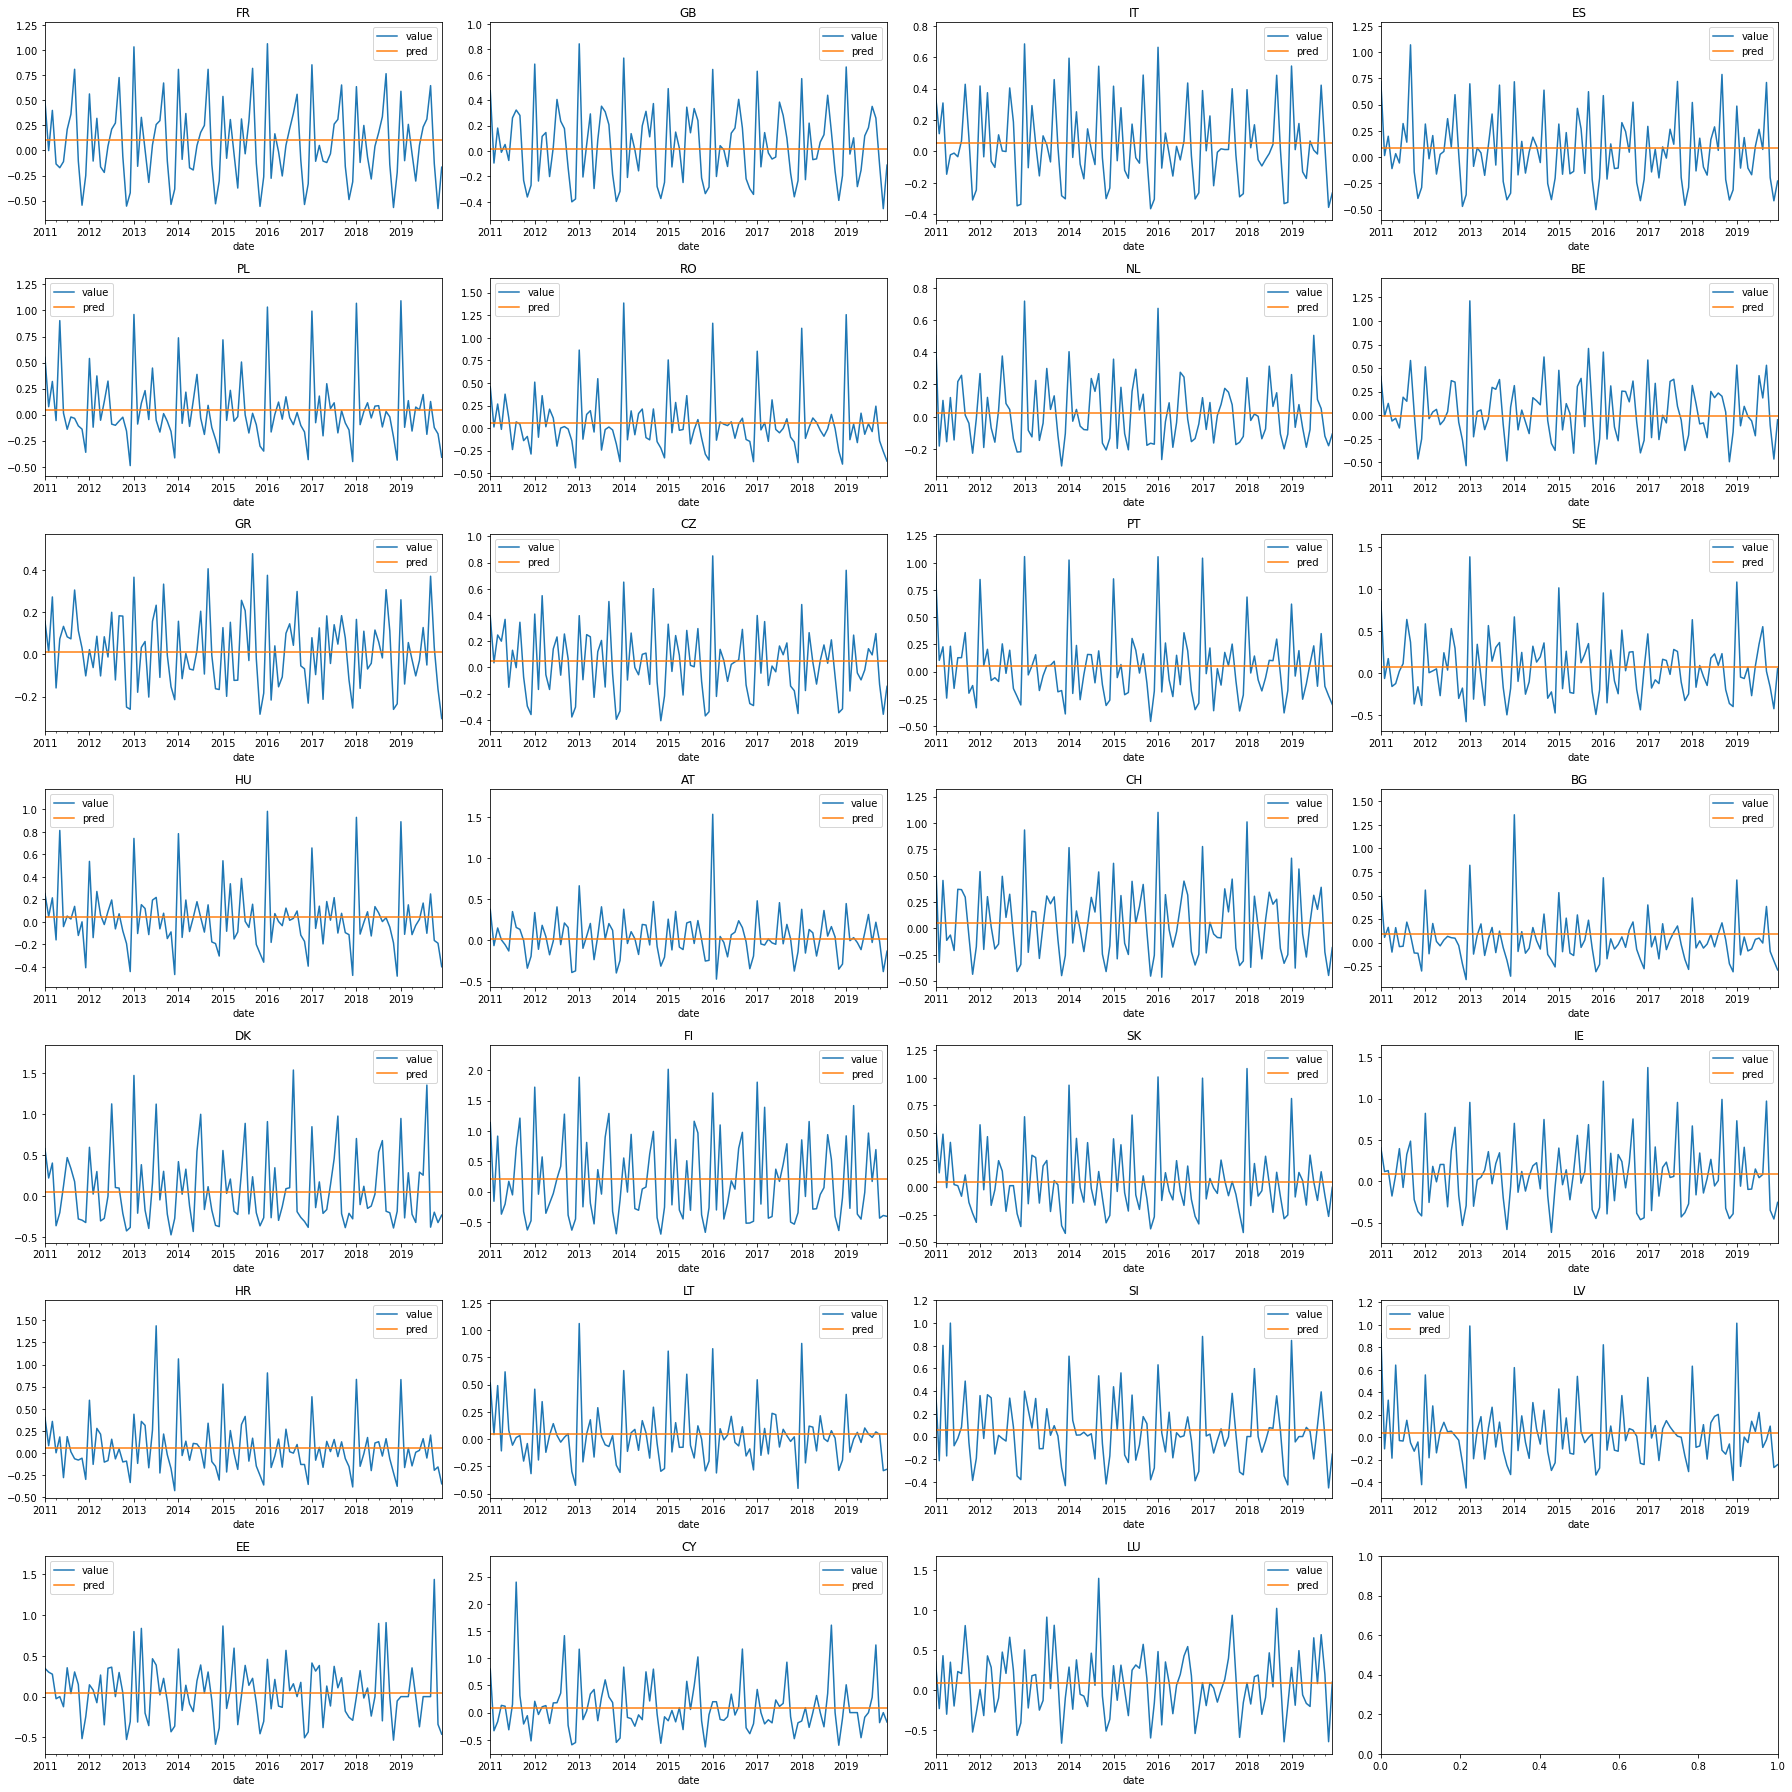

In [7]:
features = dummy_cols

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



### country + time dummies

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.014688    0.013341                            -9.299834e+11   
1  0.009519    0.006059                            -2.722139e+12   
2  0.014598    0.016452                            -1.469988e+00   
3  0.031872    0.005149                            -1.417472e+12   
4  0.011836    0.005209                            -6.873768e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.261327  0.380470  
1                         -0.240539  0.564940  
2                         -0.200633  0.689776  
3                         -0.220237  0.593312  
4                         -0.227063  0.541543

Mean CV score:


fit_time                                   1.650257e-02
score_time                                 9.242058e-03
test_neg_mean_absolute_percentage_error   -2.388672e+12
test_neg_root_mean_squared_error          -2.299598e-01
test_r2                                    5.540085e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.773633e+13
neg_root_mean_squared_error          -2.263486e-01
r2                                    5.505118e-01
dtype: float64

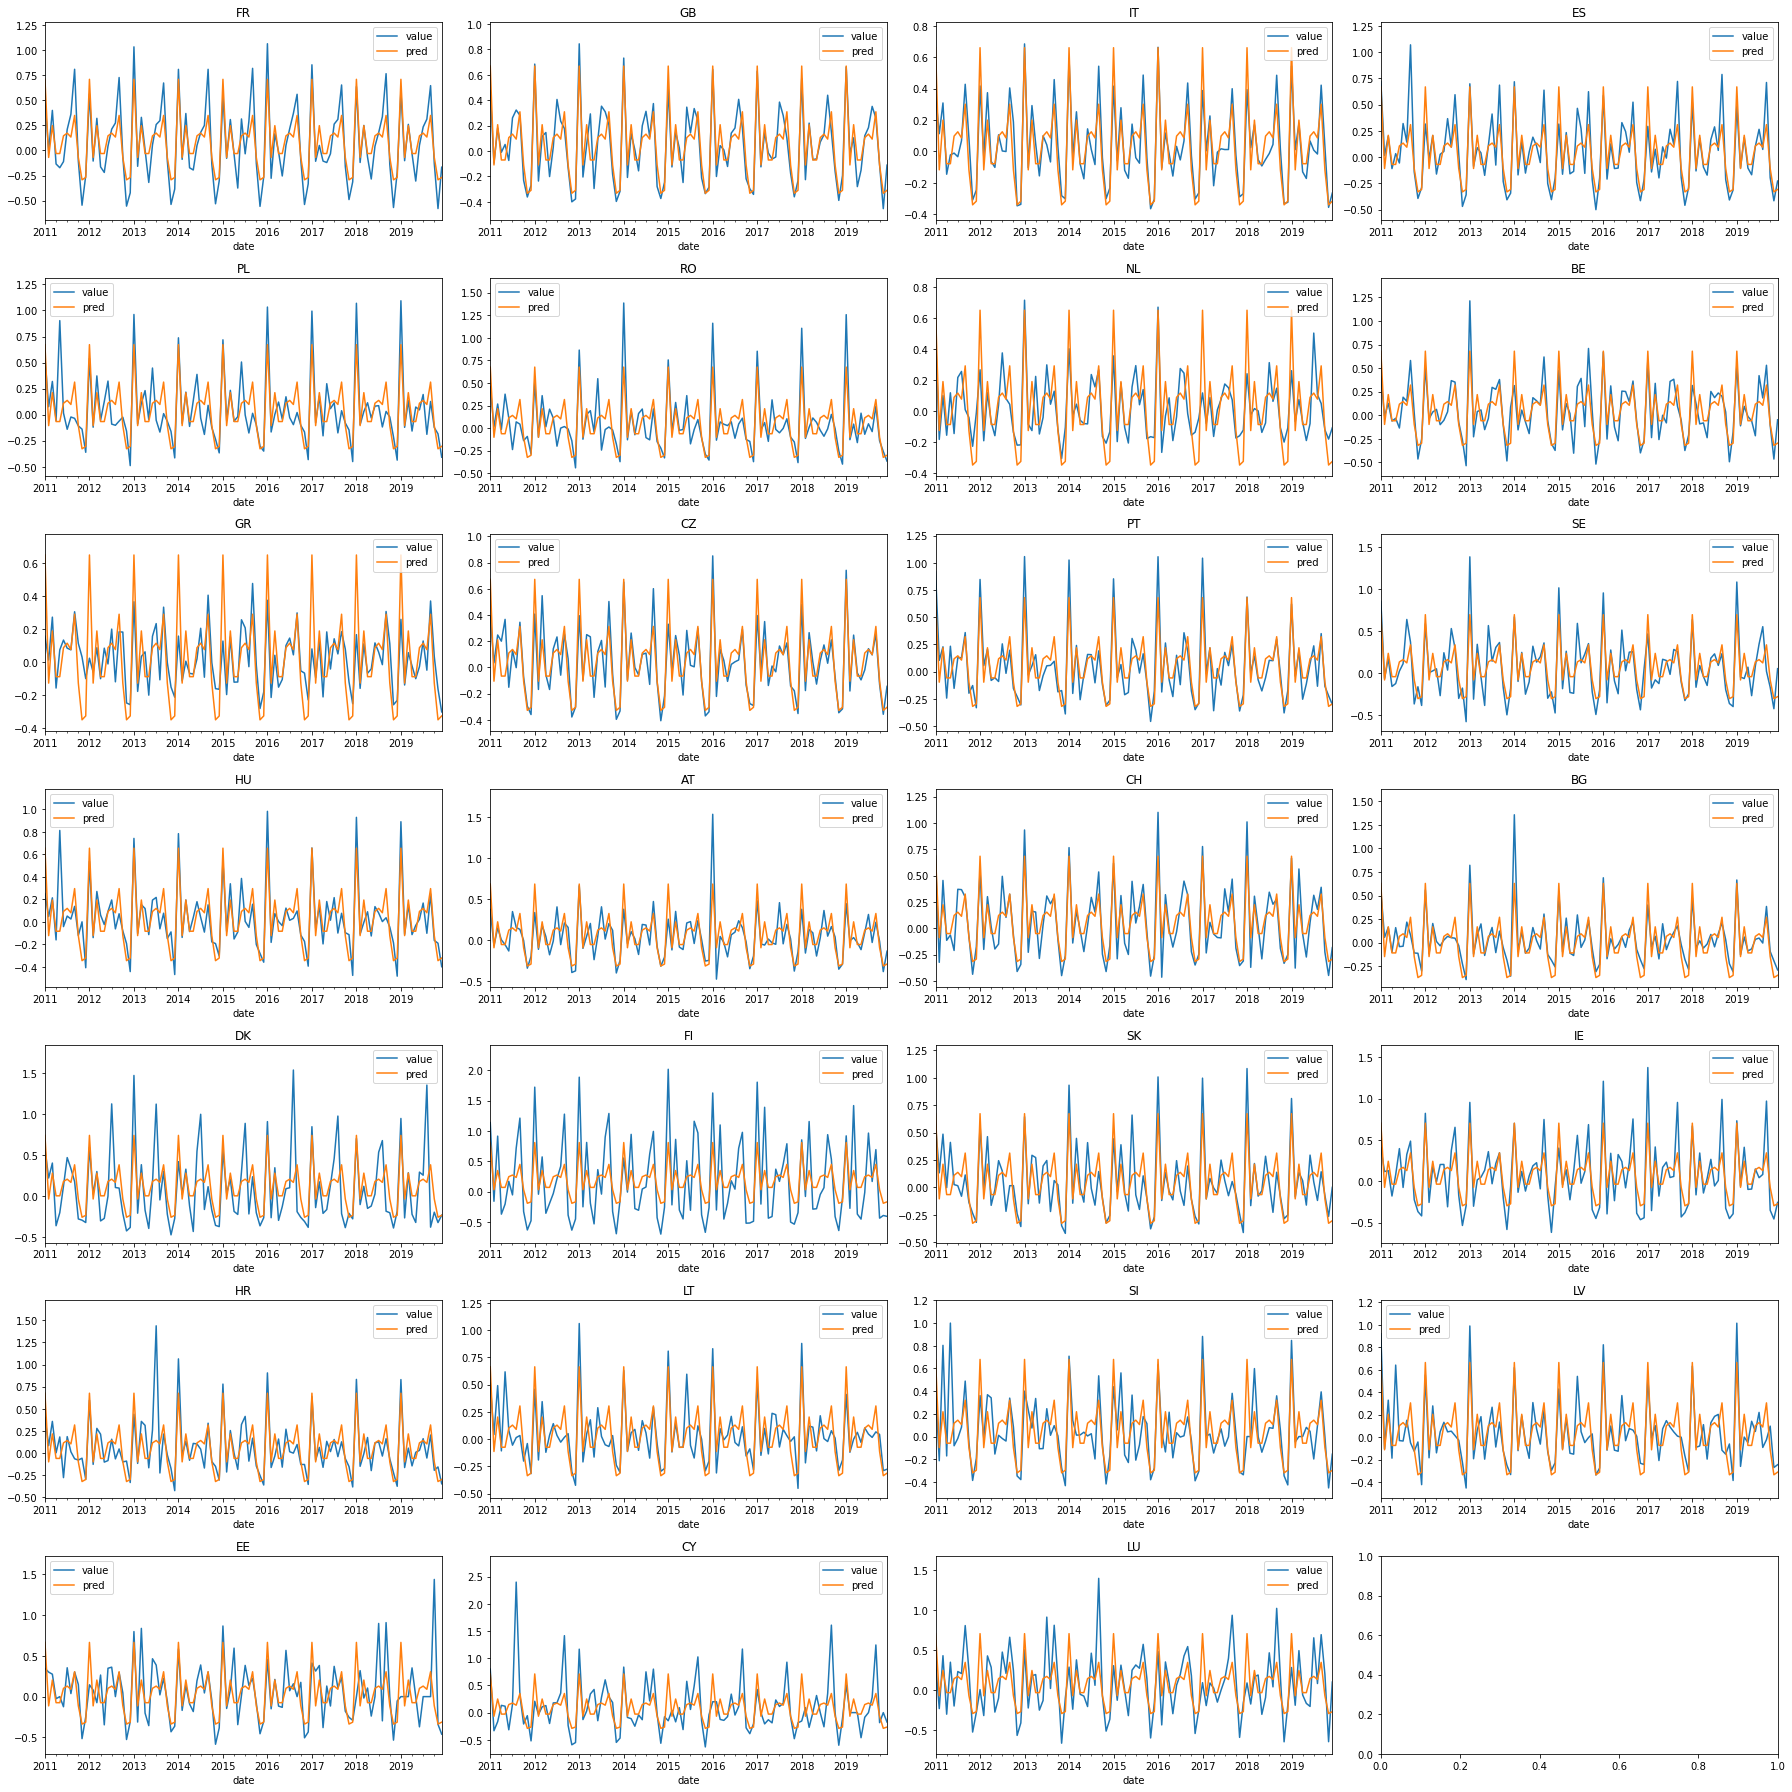

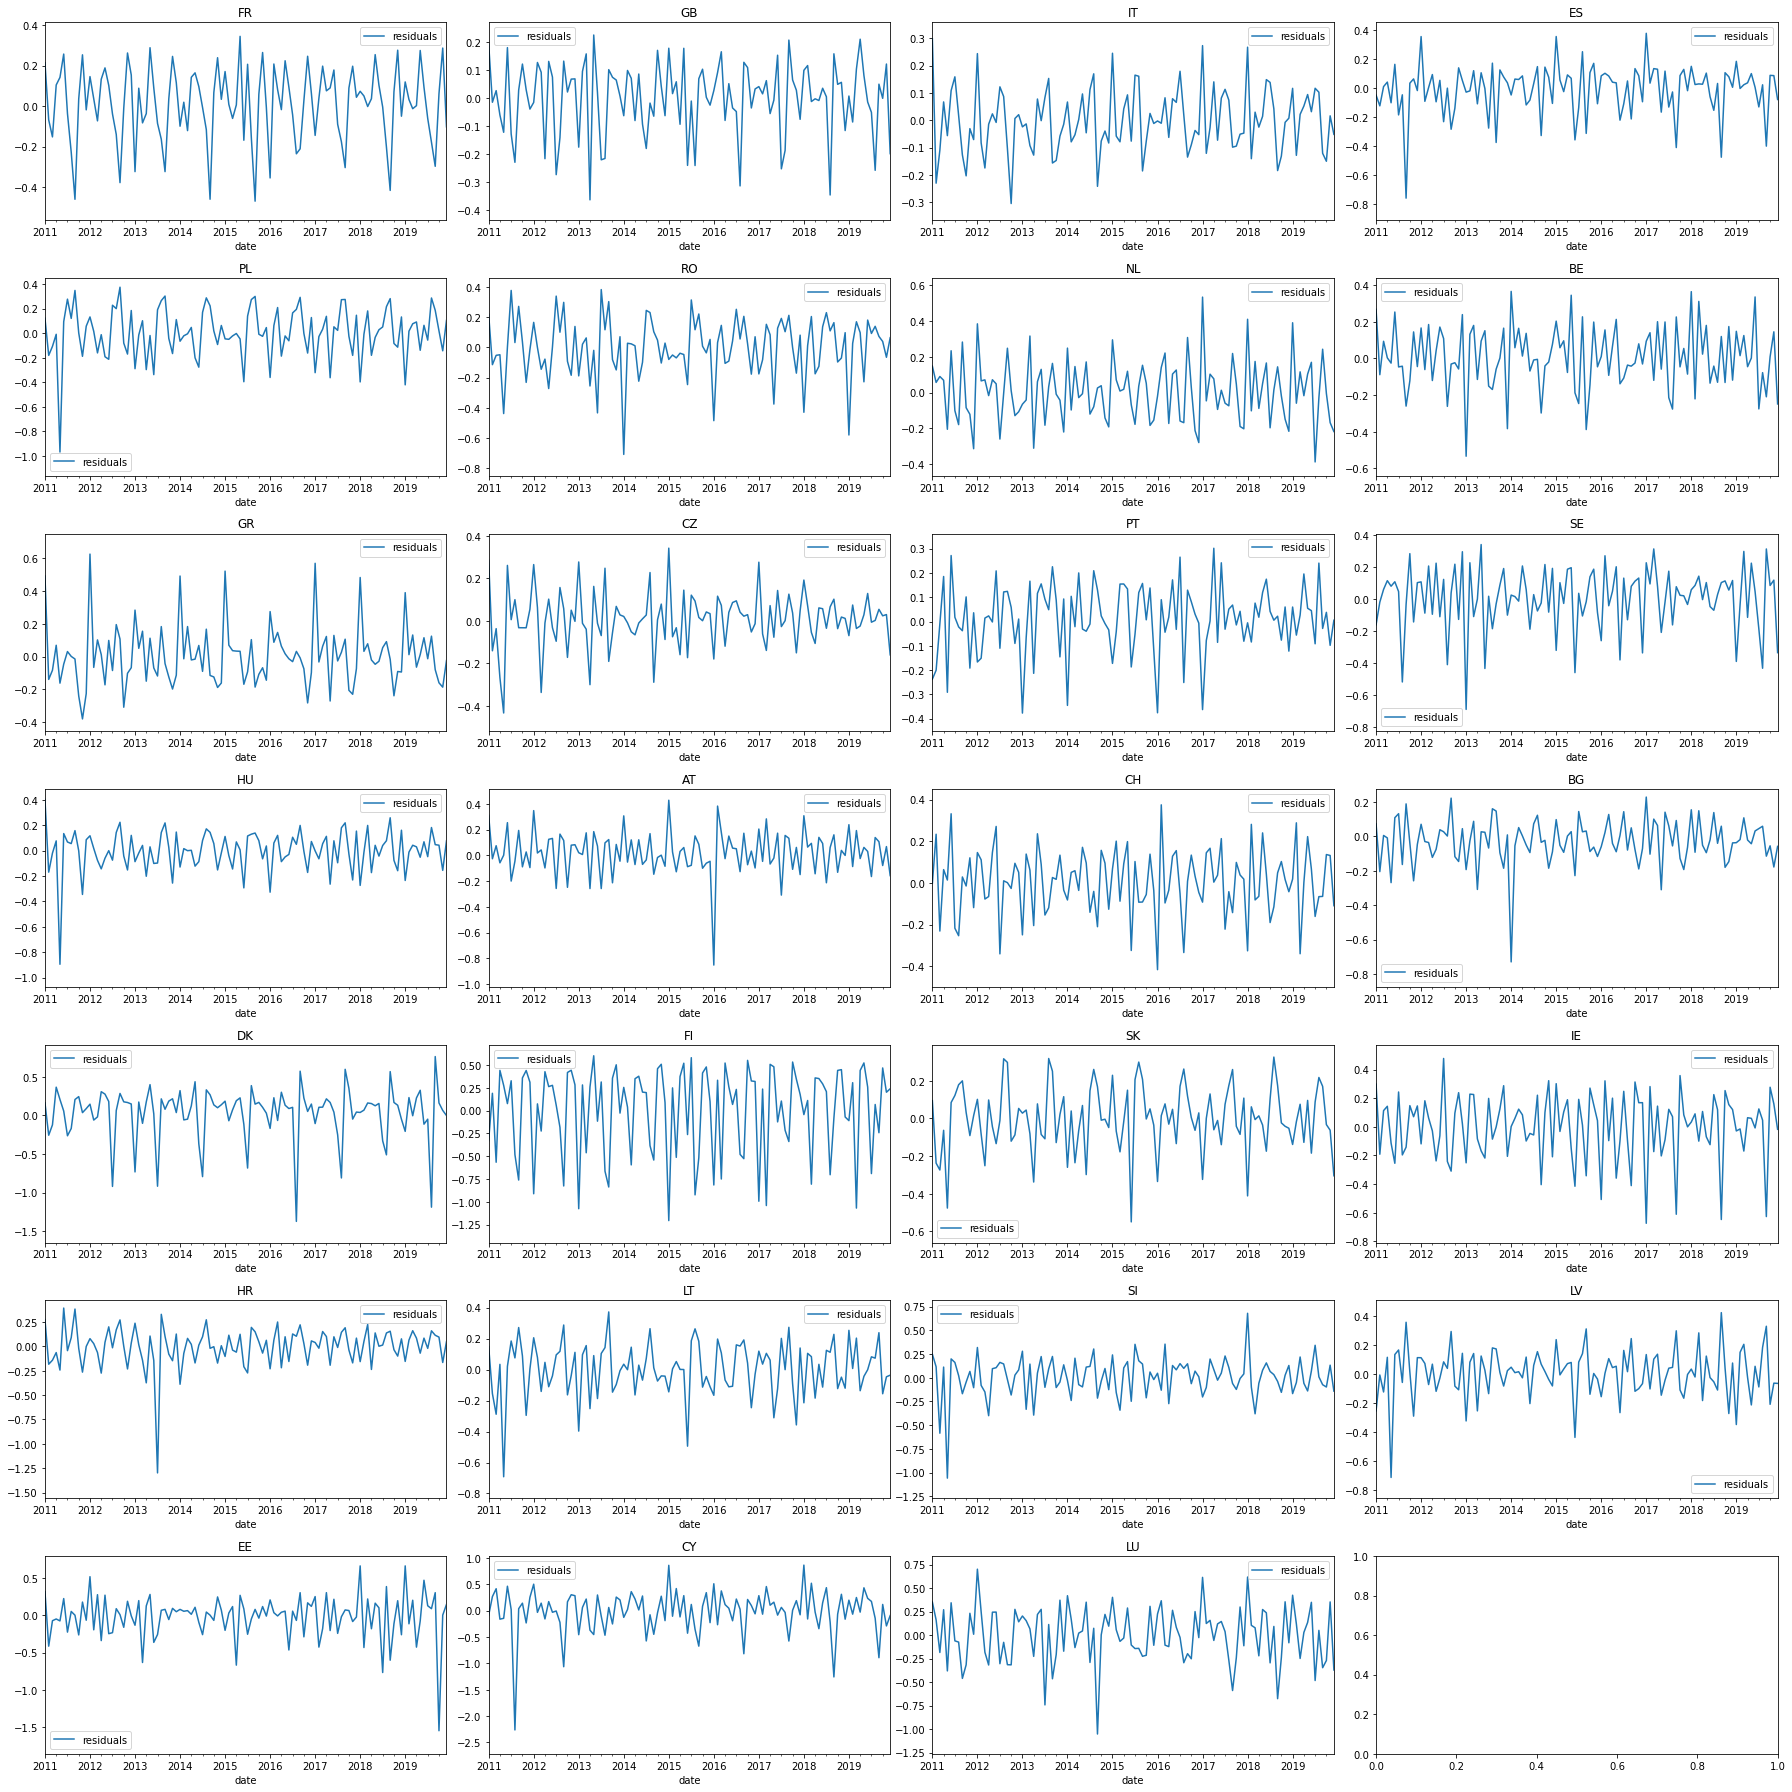

In [8]:
features = dummy_cols + dummy_cols_month

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])



### dummy matrix country plus month 

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.042726    0.005277                            -2.040393e+12   
1  0.033825    0.005416                            -3.313066e+12   
2  0.038869    0.008421                            -1.017358e+00   
3  0.037868    0.007682                            -9.514538e+11   
4  0.037274    0.008801                            -5.621344e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.219447  0.563130  
1                         -0.188098  0.733960  
2                         -0.161204  0.799728  
3                         -0.185199  0.712419  
4                         -0.166325  0.754009

Mean CV score:


fit_time                                   3.811245e-02
score_time                                 7.119370e-03
test_neg_mean_absolute_percentage_error   -2.385251e+12
test_neg_root_mean_squared_error          -1.840545e-01
test_r2                                    7.126492e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.479072e+13
neg_root_mean_squared_error          -1.750983e-01
r2                                    7.310160e-01
dtype: float64

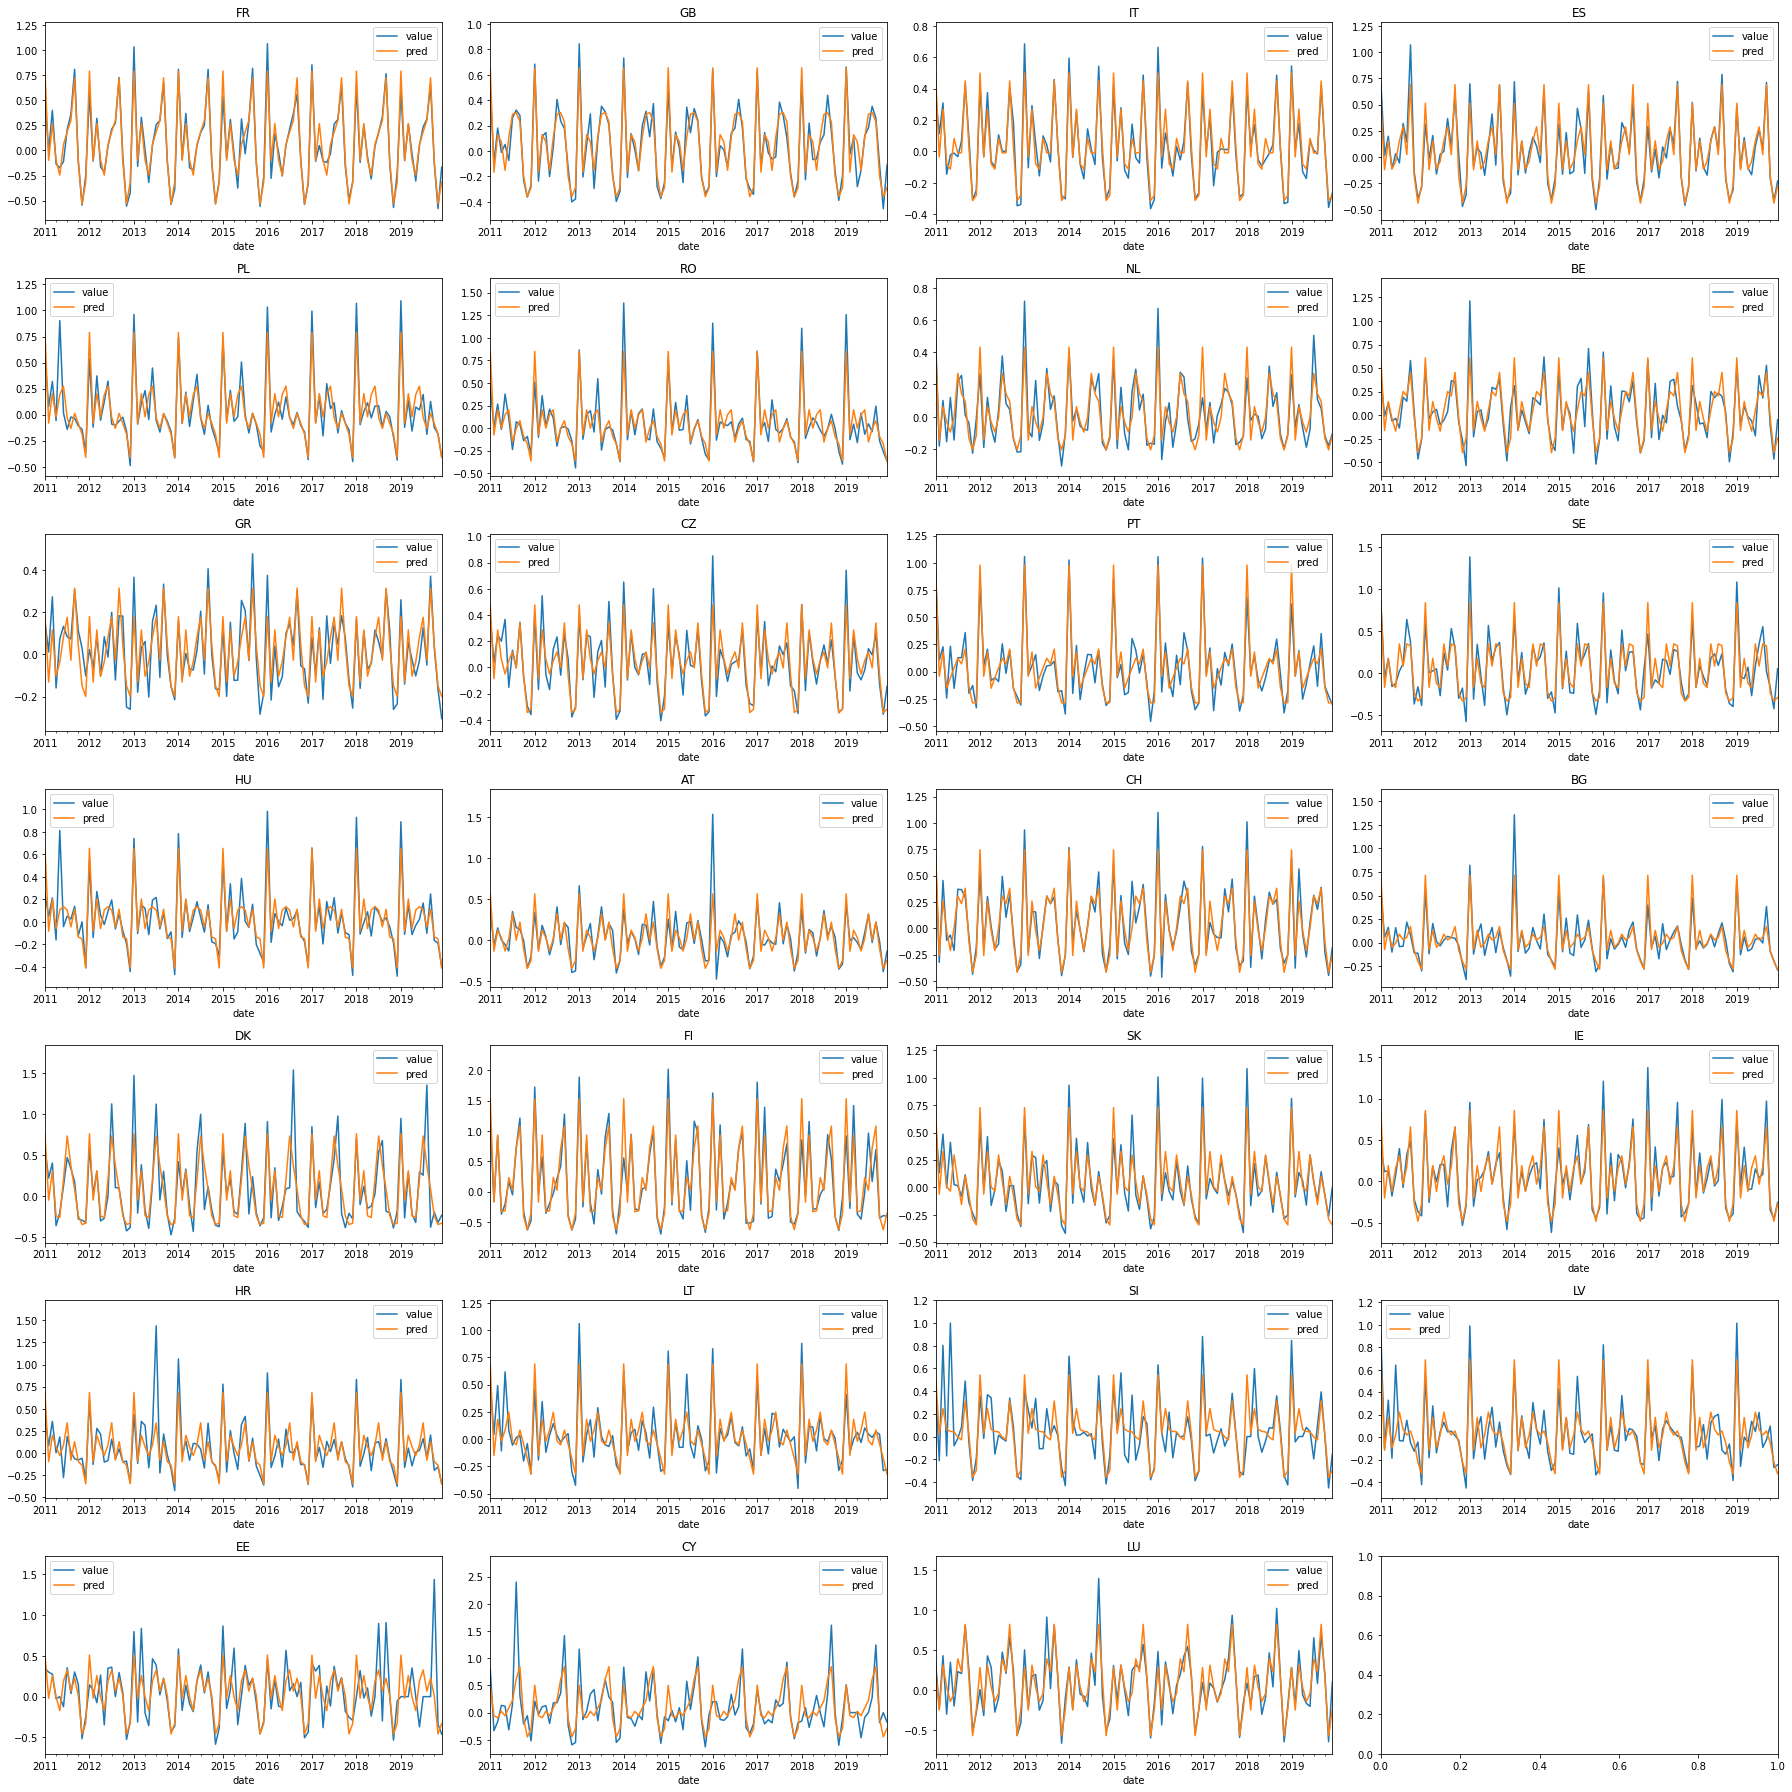

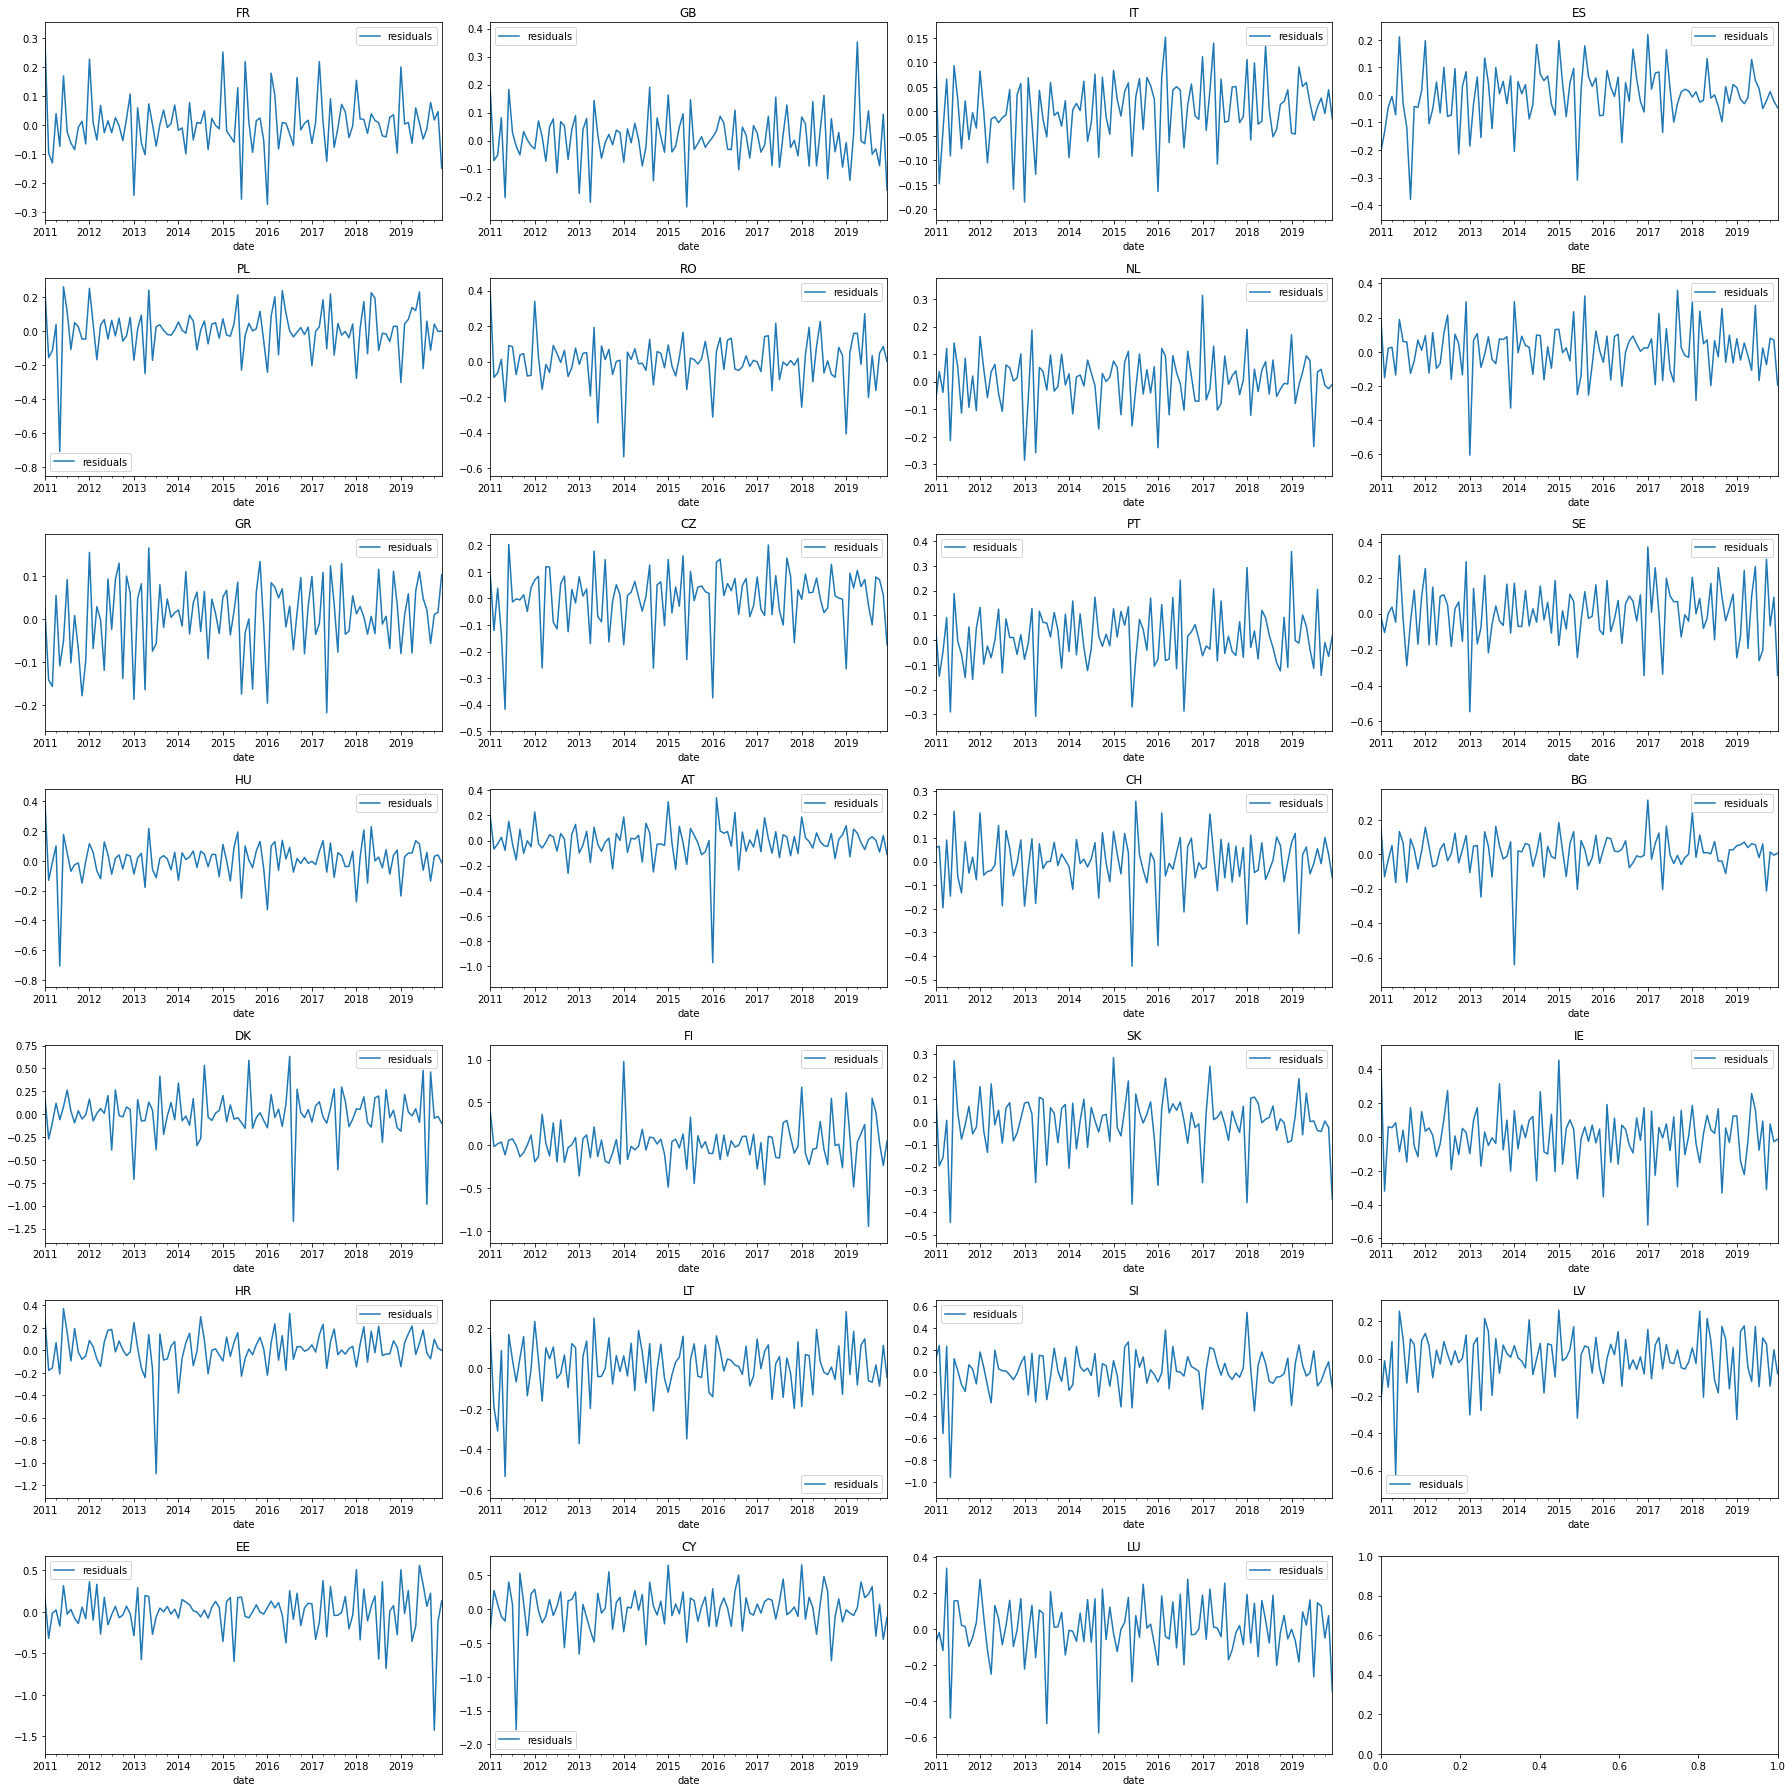

In [9]:
features = dummy_cols_combined

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])



### plus GTI

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.258206      0.077110         0.006028        0.002273     0.00001   
1        0.078714      0.038816         0.004403        0.001002      0.0001   
2        0.022805      0.003348         0.003581        0.000519       0.001   
3        0.017327      0.002769         0.004256        0.000590        0.01   
4        0.018069      0.001037         0.004225        0.000622       0.002   
5        0.018850      0.004466         0.003714        0.000708       0.005   
6        0.026936      0.008278         0.007613        0.003153         0.1   
7        0.038839      0.012066         0.014878        0.019337         0.2   
8        0.032486      0.012018         0.005330        0.001262         0.5   
9        0.013258      0.000873         0.003120        0.000056         1.0   
10       0.017159      0.004869         0.005695        0.002370         2.0   
11       0.011619      0.000725         0.003409        0.000560         5.0   
12       0.011092      0.002057         0.003701        0.000536        10.0   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.221979          -0.185676          -0.160151   
1           -0.218161          -0.190922          -0.162624   
2           -0.265288          -0.294085          -0.278669   
3           -0.314600          -0.350853          -0.330782   
4           -0.299894          -0.337904          -0.318780   
5           -0.314818          -0.351036          -0.330792   
6           -0.314283          -0.352224          -0.334907   
7           -0.314081          -0.352569          -0.338908   
8           -0.320366          -0.356488          -0.348139   
9           -0.334696          -0.366947          -0.361635   
10          -0.334696          -0.366947          -0.361635   
11          -0.334696          -0.366947          -0.361635   
12          -0.334696          -0.366947          -0.361635   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.188752          -0.166340        -0.184580        0.021665   
1           -0.192903          -0.160847        -0.185091        0.021360   
2           -0.280920          -0.249821        -0.273757        0.015055   
3           -0.333366          -0.311085        -0.328137        0.014313   
4           -0.321779          -0.295984        -0.314868        0.015327   
5           -0.333540          -0.311022        -0.328242        0.014359   
6           -0.333284          -0.313880        -0.329715        0.014389   
7           -0.333111          -0.317029        -0.331140        0.014238   
8           -0.336791          -0.326159        -0.337589        0.013389   
9           -0.345356          -0.338935        -0.349514        0.012646   
10          -0.345356          -0.338935        -0.349514        0.012646   
11          -0.345356          -0.338935        -0.349514        0.012646   
12          -0.345356          -0.338935        -0.349514        0.012646   

    rank_test_score  
0                 1  
1                 2  
2                 3  
3                 5  
4                 4  
5                 6  
6                 7  
7                 8  
8                 9  
9                10  
10               10  
11               10  
12               10

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.189800    0.006696                            -2.027491e+12   
1  0.252459    0.009202                            -4.085368e+12   
2  0.189647    0.006259                            -1.098344e+00   
3  0.278593    0.013407                            -1.094136e+12   
4  0.394711    0.017516                            -6.885060e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.221979  0.552989  
1                         -0.185676  0.740768  
2                         -0.160151  0.802335  
3                         -0.188752  0.701278  
4                         -0.166340  0.753965

Mean CV score:


fit_time                                   2.610420e-01
score_time                                 1.061597e-02
test_neg_mean_absolute_percentage_error   -2.818411e+12
test_neg_root_mean_squared_error          -1.845796e-01
test_r2                                    7.102671e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.434865e+13
neg_root_mean_squared_error          -1.783224e-01
r2                                    7.210191e-01
dtype: float64

LASSO Coefficients:
AT_1     0.437154
AT_10    0.068899
AT_11   -0.361186
AT_12   -0.260941
AT_2    -0.046442
AT_3     0.071217
AT_4     0.005522
AT_5    -0.185255
AT_6     0.010013
AT_7     0.231179
AT_8    -0.011273
AT_9     0.202087
BE_1     0.515644
BE_10    0.003816
BE_11   -0.441630
BE_12   -0.315430
BE_2    -0.125083
BE_3     0.159632
BE_4    -0.100299
BE_5    -0.202125
BE_6     0.067970
BE_7     0.249808
BE_8     0.136219
BE_9     0.386550
BG_1     0.566059
BG_10   -0.047377
BG_11   -0.206050
BG_12   -0.328349
BG_2    -0.006408
BG_3     0.107805
BG_4    -0.070391
BG_5    -0.074426
BG_6     0.042994
BG_7     0.031915
BG_8     0.017392
BG_9     0.109793
CH_1     0.632973
CH_10   -0.101746
CH_11   -0.430218
CH_12   -0.269197
CH_2    -0.141079
CH_3     0.259302
CH_4    -0.067881
CH_5    -0.230594
CH_6    -0.046678
CH_7     0.262533
CH_8     0.198256
CH_9     0.366022
CY_1     0.442404
CY_10   -0.053996
CY_11   -0.555682
CY_12   -0.326949
CY_2    -0.002618
CY_3    -0.145251
CY_4    

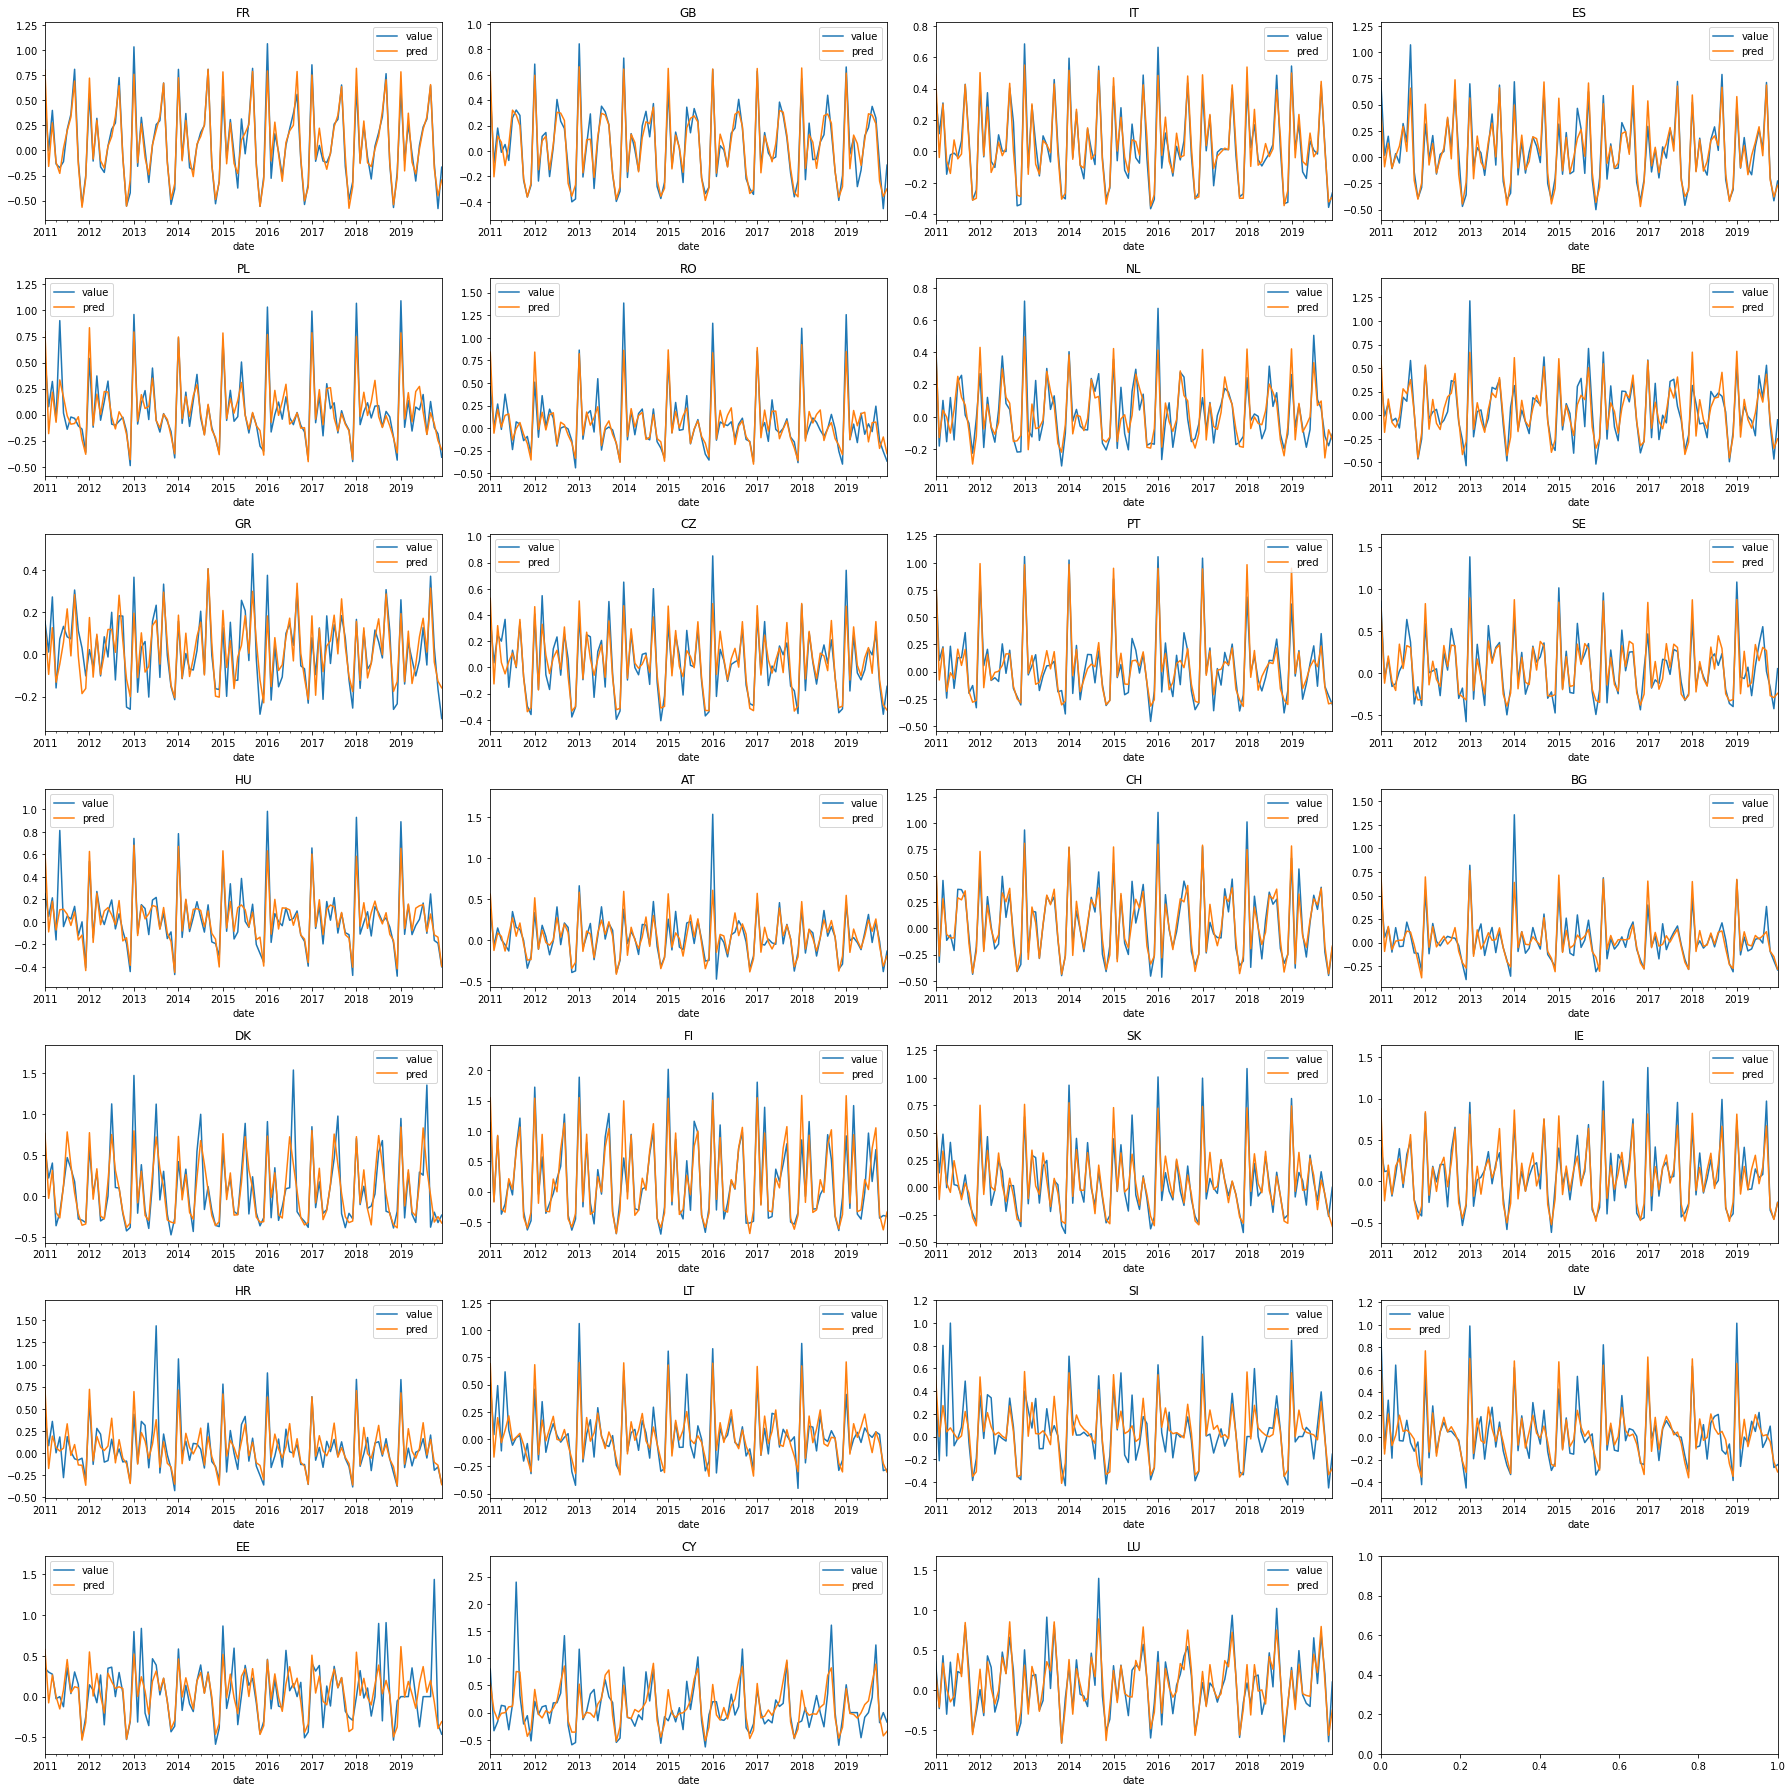

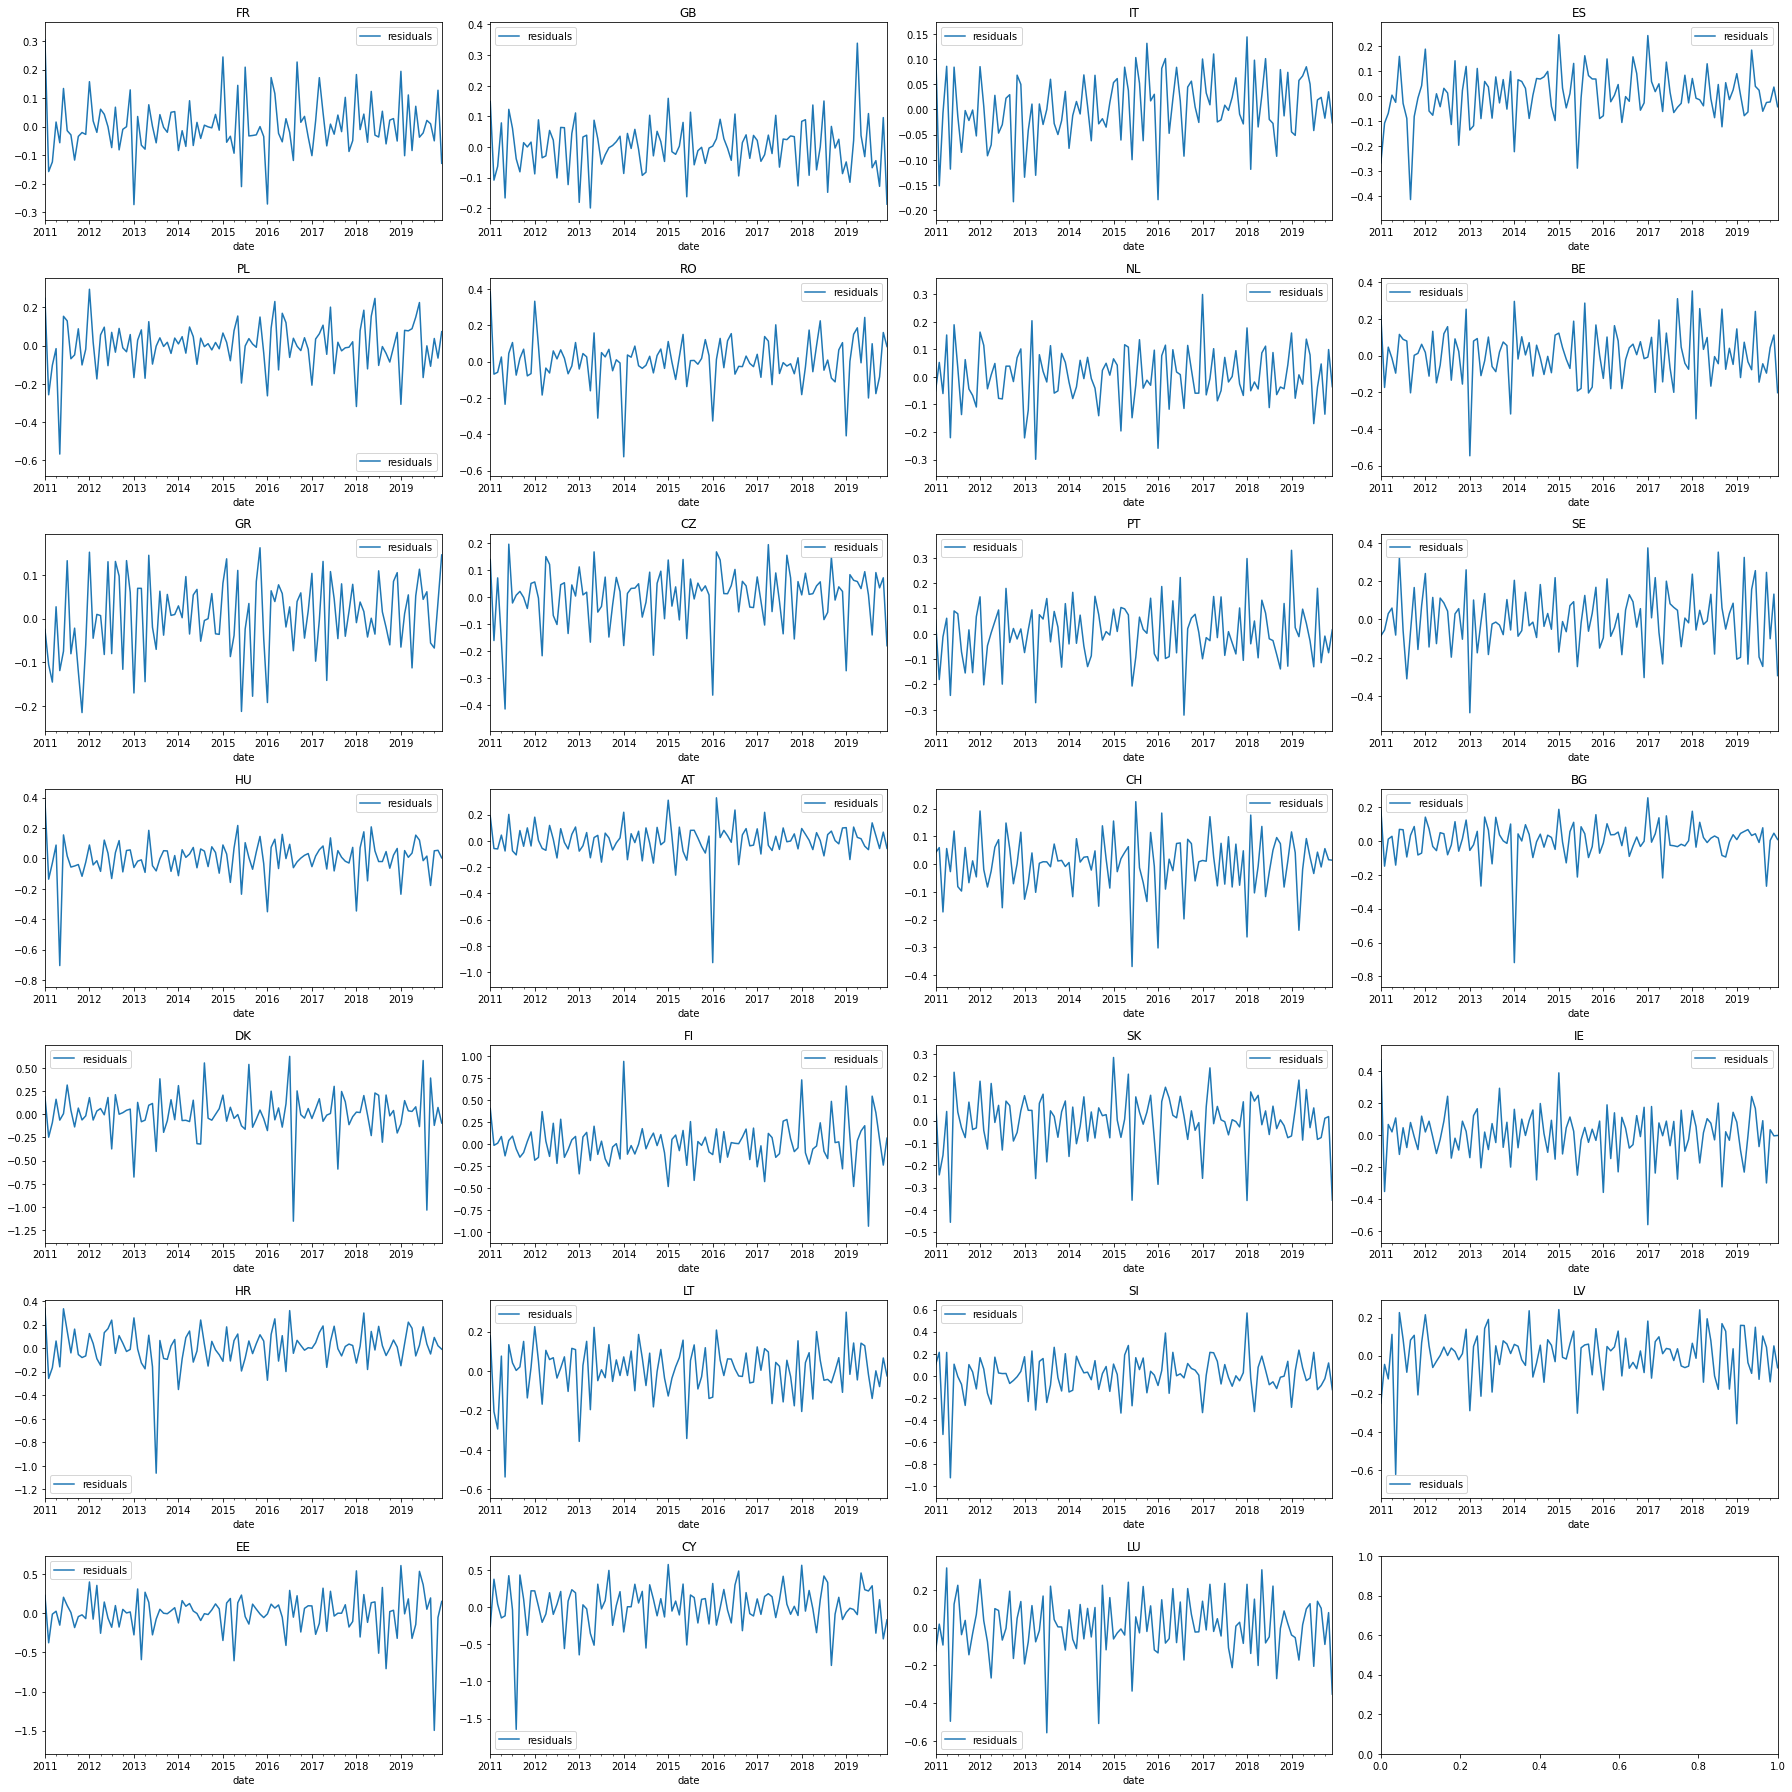

In [11]:
features = dummy_cols_combined + keyword_ids

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(normalize=False)
params = {
    "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.002, 0.005, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())



mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.258206      0.077110         0.006028        0.002273     0.00001   
1        0.078714      0.038816         0.004403        0.001002      0.0001   
2        0.022805      0.003348         0.003581        0.000519       0.001   
3        0.017327      0.002769         0.004256        0.000590        0.01   
4        0.018069      0.001037         0.004225        0.000622       0.002   
5        0.018850      0.004466         0.003714        0.000708       0.005   
6        0.026936      0.008278         0.007613        0.003153         0.1   
7        0.038839      0.012066         0.014878        0.019337         0.2   
8        0.032486      0.012018         0.005330        0.001262         0.5   
9        0.013258      0.000873         0.003120        0.000056         1.0   
10       0.017159      0.004869         0.005695        0.002370         2.0   
11       0.011619      0.000725         0.003409        0.000560         5.0   
12       0.011092      0.002057         0.003701        0.000536        10.0   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.221979          -0.185676          -0.160151   
1           -0.218161          -0.190922          -0.162624   
2           -0.265288          -0.294085          -0.278669   
3           -0.314600          -0.350853          -0.330782   
4           -0.299894          -0.337904          -0.318780   
5           -0.314818          -0.351036          -0.330792   
6           -0.314283          -0.352224          -0.334907   
7           -0.314081          -0.352569          -0.338908   
8           -0.320366          -0.356488          -0.348139   
9           -0.334696          -0.366947          -0.361635   
10          -0.334696          -0.366947          -0.361635   
11          -0.334696          -0.366947          -0.361635   
12          -0.334696          -0.366947          -0.361635   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.188752          -0.166340        -0.184580        0.021665   
1           -0.192903          -0.160847        -0.185091        0.021360   
2           -0.280920          -0.249821        -0.273757        0.015055   
3           -0.333366          -0.311085        -0.328137        0.014313   
4           -0.321779          -0.295984        -0.314868        0.015327   
5           -0.333540          -0.311022        -0.328242        0.014359   
6           -0.333284          -0.313880        -0.329715        0.014389   
7           -0.333111          -0.317029        -0.331140        0.014238   
8           -0.336791          -0.326159        -0.337589        0.013389   
9           -0.345356          -0.338935        -0.349514        0.012646   
10          -0.345356          -0.338935        -0.349514        0.012646   
11          -0.345356          -0.338935        -0.349514        0.012646   
12          -0.345356          -0.338935        -0.349514        0.012646   

    rank_test_score  
0                 1  
1                 2  
2                 3  
3                 5  
4                 4  
5                 6  
6                 7  
7                 8  
8                 9  
9                10  
10               10  
11               10  
12               10

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.189800    0.006696                            -2.027491e+12   
1  0.252459    0.009202                            -4.085368e+12   
2  0.189647    0.006259                            -1.098344e+00   
3  0.278593    0.013407                            -1.094136e+12   
4  0.394711    0.017516                            -6.885060e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.221979  0.552989  
1                         -0.185676  0.740768  
2                         -0.160151  0.802335  
3                         -0.188752  0.701278  
4                         -0.166340  0.753965

Mean CV score:


fit_time                                   2.610420e-01
score_time                                 1.061597e-02
test_neg_mean_absolute_percentage_error   -2.818411e+12
test_neg_root_mean_squared_error          -1.845796e-01
test_r2                                    7.102671e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.434865e+13
neg_root_mean_squared_error          -1.783224e-01
r2                                    7.210191e-01
dtype: float64

LASSO Coefficients:
AT_1     0.437154
AT_10    0.068899
AT_11   -0.361186
AT_12   -0.260941
AT_2    -0.046442
AT_3     0.071217
AT_4     0.005522
AT_5    -0.185255
AT_6     0.010013
AT_7     0.231179
AT_8    -0.011273
AT_9     0.202087
BE_1     0.515644
BE_10    0.003816
BE_11   -0.441630
BE_12   -0.315430
BE_2    -0.125083
BE_3     0.159632
BE_4    -0.100299
BE_5    -0.202125
BE_6     0.067970
BE_7     0.249808
BE_8     0.136219
BE_9     0.386550
BG_1     0.566059
BG_10   -0.047377
BG_11   -0.206050
BG_12   -0.328349
BG_2    -0.006408
BG_3     0.107805
BG_4    -0.070391
BG_5    -0.074426
BG_6     0.042994
BG_7     0.031915
BG_8     0.017392
BG_9     0.109793
CH_1     0.632973
CH_10   -0.101746
CH_11   -0.430218
CH_12   -0.269197
CH_2    -0.141079
CH_3     0.259302
CH_4    -0.067881
CH_5    -0.230594
CH_6    -0.046678
CH_7     0.262533
CH_8     0.198256
CH_9     0.366022
CY_1     0.442404
CY_10   -0.053996
CY_11   -0.555682
CY_12   -0.326949
CY_2    -0.002618
CY_3    -0.145251
CY_4    

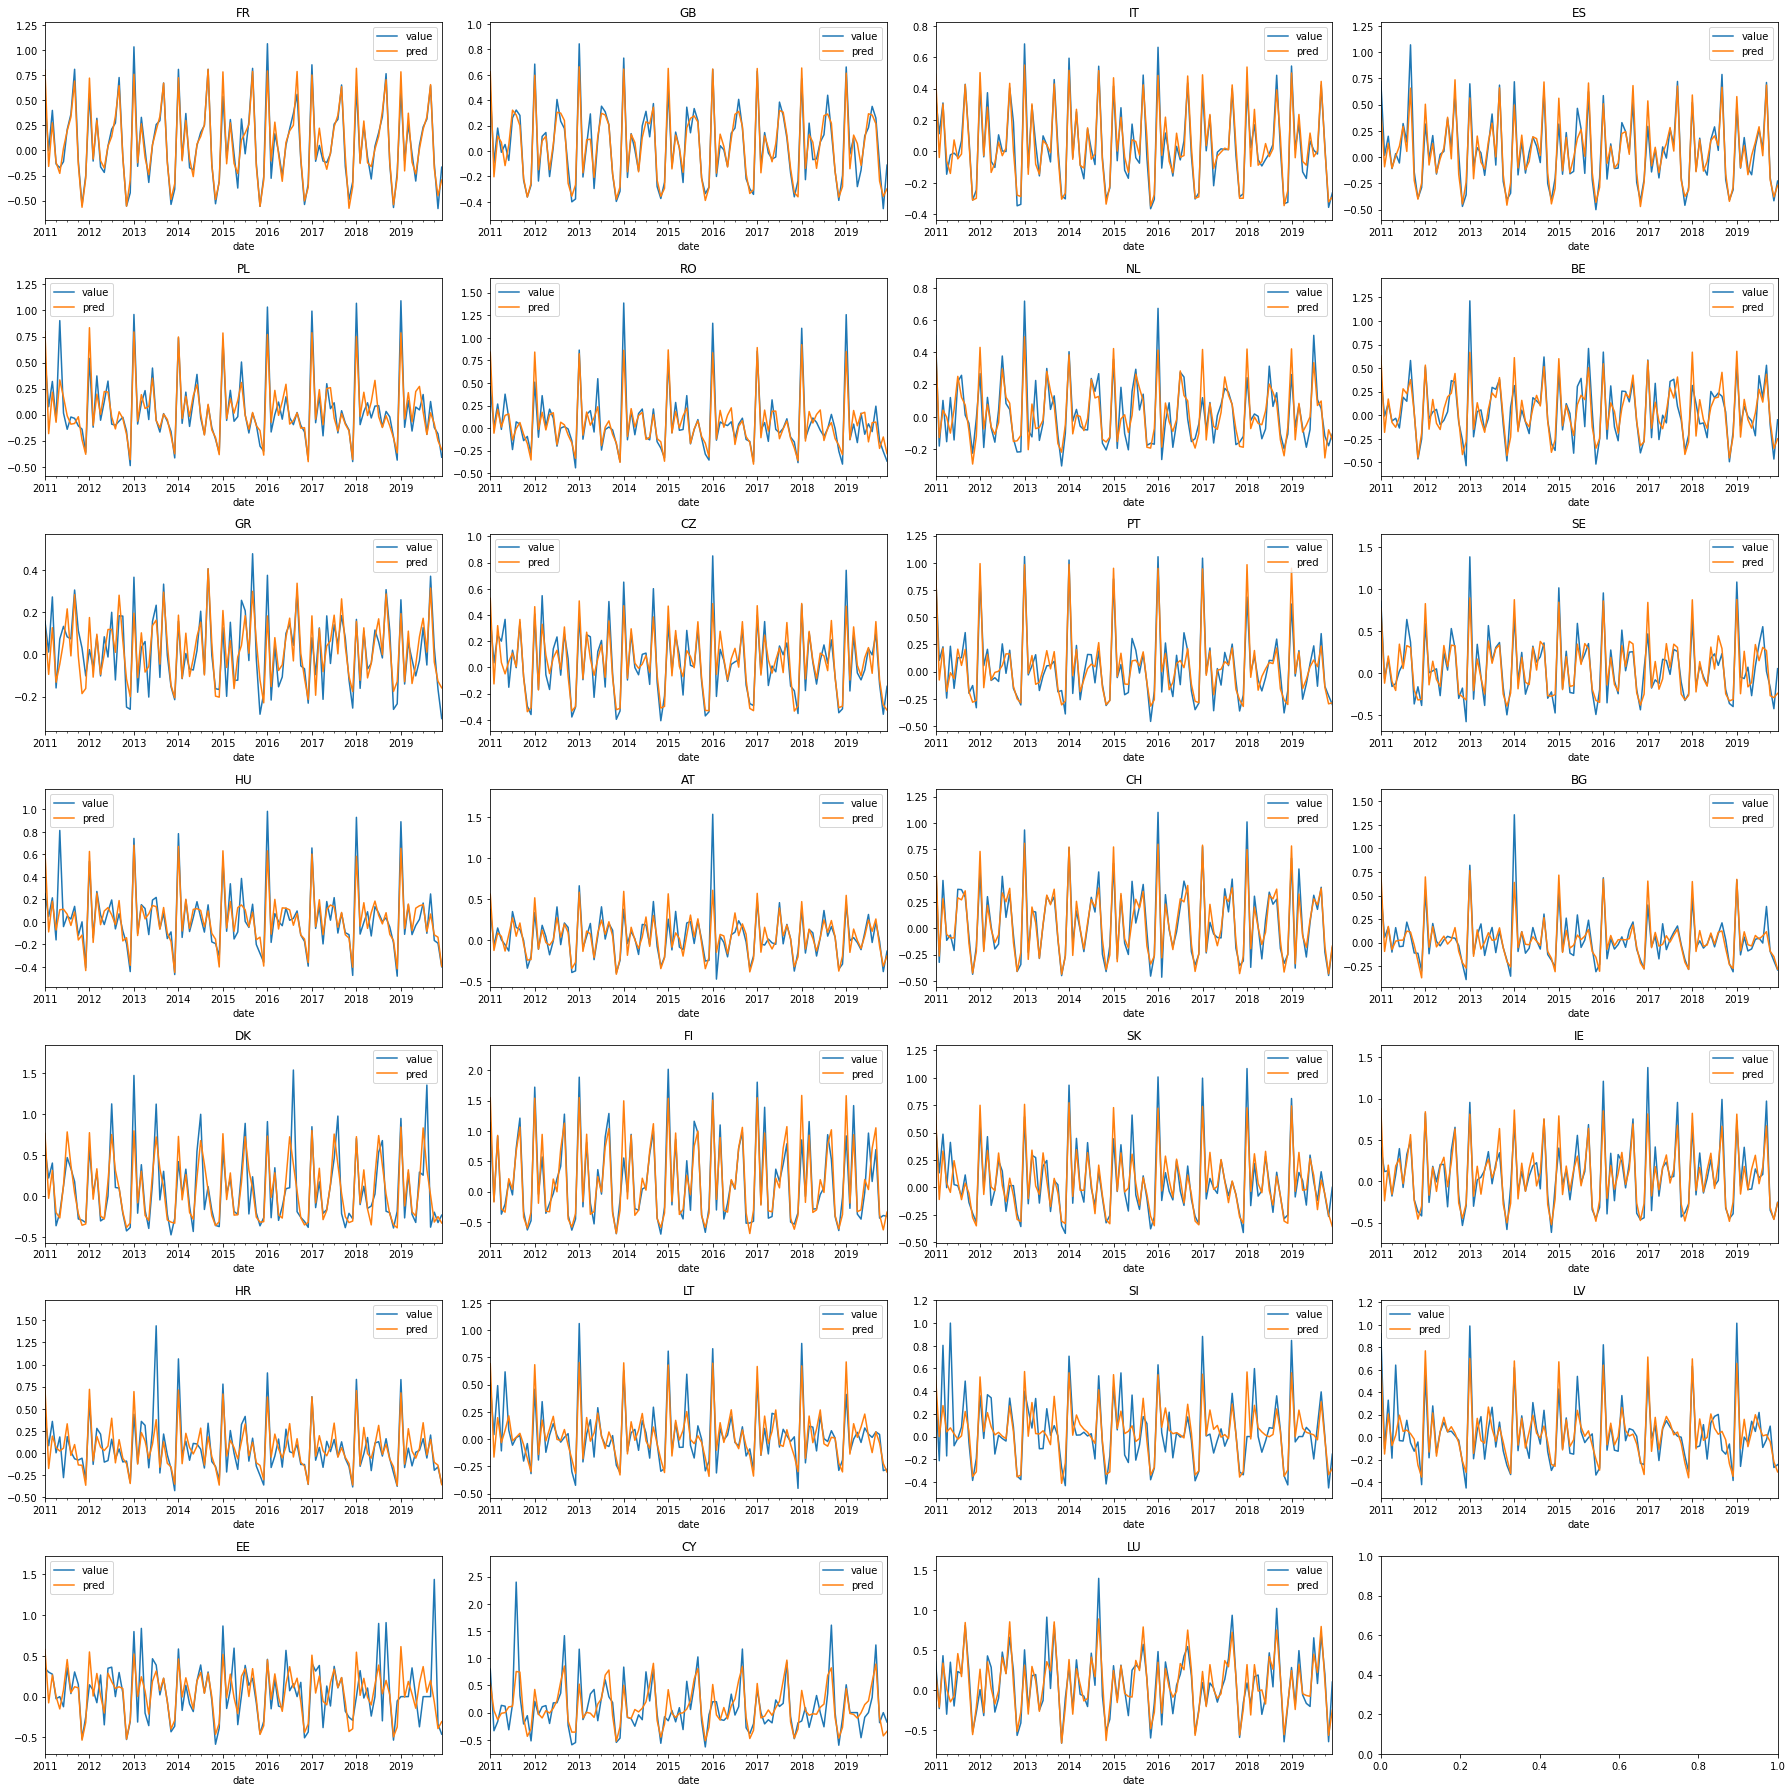

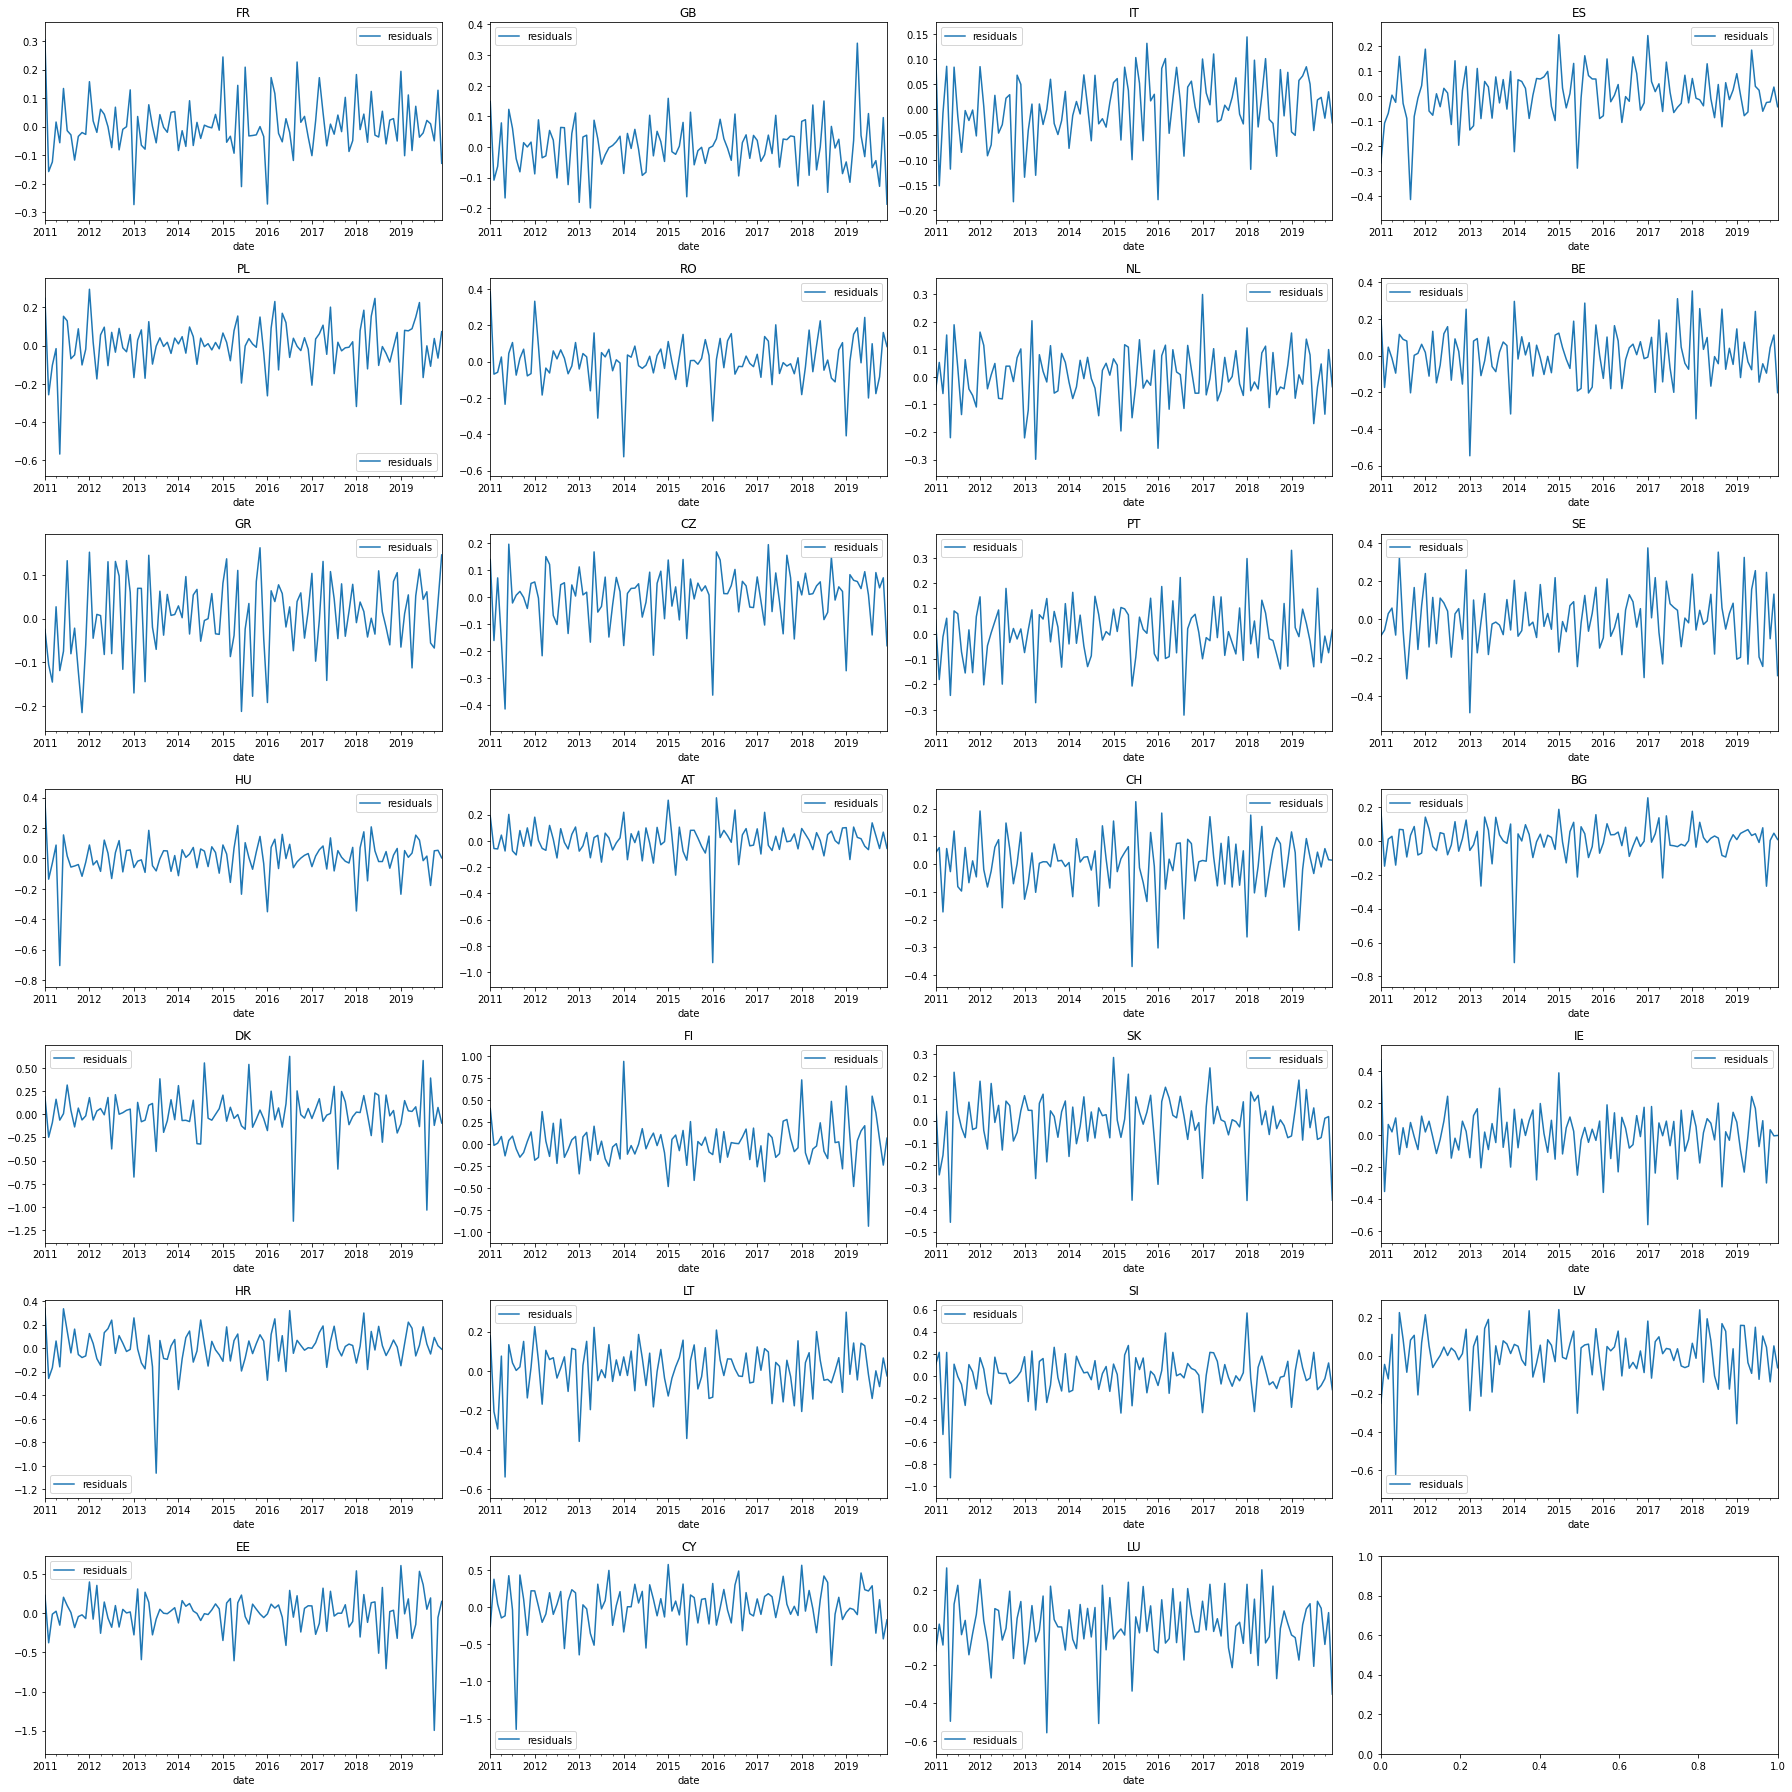

In [ ]:
features = dummy_cols + dummy_cols_month + keyword_ids

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(normalize=False)
params = {
    "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.002, 0.005, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).to_string())

